In [14]:
import wandb
import numpy as np
import sys
import torch
import torch.utils.data as Data
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import torch.nn as nn
import glob
import xarray as xr
import matplotlib.pyplot as plt


BASE = '/scratch/ab10313/pleiades_new/'
PATH_NN_1= BASE+'NN_data_1/'
PATH_NN_1_2= BASE+'NN_data_1_2/'
PATH_NN_1_4= BASE+'NN_data_1_4/'
PATH_NN_1_8= BASE+'NN_data_1_8/'
PATH_NN_1_12= BASE+'NN_data_1_12/'


import submeso_ml.systems.regression_system as regression_system
import submeso_ml.models.fcnn as fcnn
import submeso_ml.data.dataset as dataset

# Define X,Y pairs (state, subgrid fluxes) for local network.local_torch_dataset = Data.TensorDataset(
BATCH_SIZE = 64  # Number of sample in each batch



In [15]:
it = 0

In [16]:
WB_sg_mean_1 = np.load(PATH_NN_1+'WB_sg_mean.npy')
WB_sg_std_1 = np.load(PATH_NN_1+'WB_sg_std.npy')
WB_sg_1 = np.load(PATH_NN_1+'WB_sg.npy')[it]

WB_sg_mean_1_2 = np.load(PATH_NN_1_2+'WB_sg_mean.npy')
WB_sg_std_1_2 = np.load(PATH_NN_1_2+'WB_sg_std.npy')
WB_sg_1_2 = np.load(PATH_NN_1_2+'WB_sg.npy')[it]

WB_sg_mean_1_8 = np.load(PATH_NN_1_8+'WB_sg_mean.npy')
WB_sg_std_1_8 = np.load(PATH_NN_1_8+'WB_sg_std.npy')
WB_sg_1_8 = np.load(PATH_NN_1_8+'WB_sg.npy')[it]

WB_sg_mean_1_12 = np.load(PATH_NN_1_12+'WB_sg_mean.npy')
WB_sg_std_1_12 = np.load(PATH_NN_1_12+'WB_sg_std.npy')
WB_sg_1_12 = np.load(PATH_NN_1_12+'WB_sg.npy')[it]

In [17]:

WB_1 = WB_sg_1#*WB_sg_std_1 + WB_sg_mean_1
WB_1_2 = WB_sg_1_2#*WB_sg_std_1_2 + WB_sg_mean_1_2
WB_1_8 = WB_sg_1_8#*WB_sg_std_1_8 + WB_sg_mean_1_8
WB_1_12 = WB_sg_1_12#*WB_sg_std_1_12 + WB_sg_mean_1_12

In [18]:
PATH_LIST_full = glob.glob(BASE+'*_smooth/preprcossed_data/')
i_loc=0
lat_plot = xr.open_dataarray(PATH_LIST_full[i_loc]+'lat.nc')
lon_plot = xr.open_dataarray(PATH_LIST_full[i_loc]+'lon.nc')

#grid scale 

grid_factor = 4
lat_1_12 = lat_plot.coarsen(j=grid_factor, boundary="trim").mean()
lon_1_12 = lon_plot.coarsen(i=grid_factor, boundary="trim").mean()

grid_factor = 6
lat_1_8 = lat_plot.coarsen(j=grid_factor, boundary="trim").mean()
lon_1_8 = lon_plot.coarsen(i=grid_factor, boundary="trim").mean()

grid_factor = 12
lat_1_4 = lat_plot.coarsen(j=grid_factor, boundary="trim").mean()
lon_1_4 = lon_plot.coarsen(i=grid_factor, boundary="trim").mean()

grid_factor = 24
lat_1_2 = lat_plot.coarsen(j=grid_factor, boundary="trim").mean()
lon_1_2 = lon_plot.coarsen(i=grid_factor, boundary="trim").mean()

grid_factor = 48
lat_1 = lat_plot.coarsen(j=grid_factor, boundary="trim").mean()
lon_1 = lon_plot.coarsen(i=grid_factor, boundary="trim").mean()

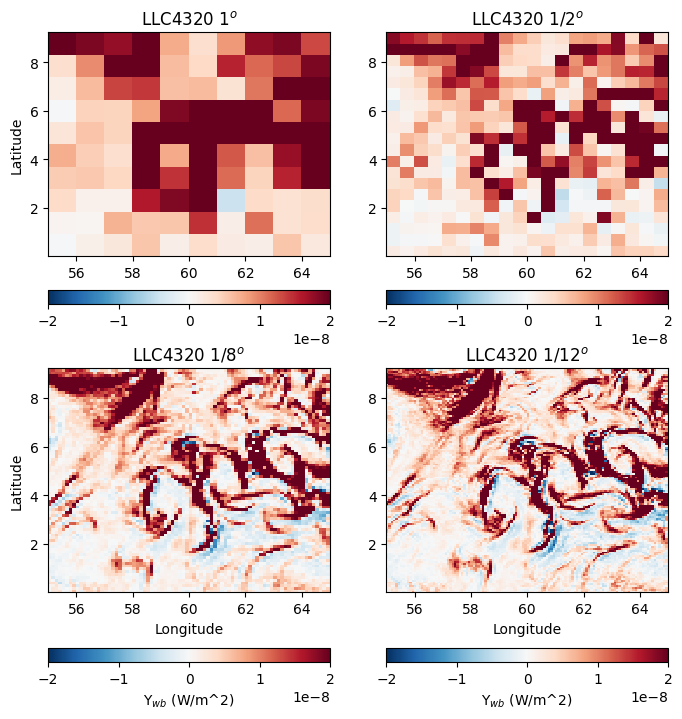

In [54]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(8,8))
#fig.tight_layout(pad=5.0)

i_loc=0
it = 107
clim = 2e-8

plt.subplot(2,2,1)
plt.pcolor(lon_1,lat_1,WB_1,cmap='RdBu_r',vmin=-clim,vmax=clim)
#plt.xticks([])
#plt.yticks([])
cb = plt.colorbar(location='bottom',pad=0.05,anchor=(.0,0.3))
#cb.set_label(r'$\overline{w^\prime b^\prime}^z$' + ' (W/m)')
plt.title('LLC4320 $1^o$',fontsize=12)
plt.ylabel('Latitude')

plt.subplot(2,2,2)
plt.pcolor(lon_1_2,lat_1_2,WB_1_2,cmap='RdBu_r',vmin=-clim,vmax=clim)
#plt.xticks([])
#plt.yticks([])
cb = plt.colorbar(location='bottom',pad=0.05,anchor=(.0,0.3))
#cb.set_label(r'$\overline{w^\prime b^\prime}^z$' + ' (W/m)')
plt.title('LLC4320 $1/2^o$',fontsize=12)

plt.subplot(2,2,3)
plt.pcolor(lon_1_8,lat_1_8,WB_1_8,cmap='RdBu_r',vmin=-clim,vmax=clim)
#plt.xticks([])
#plt.yticks([])
cb = plt.colorbar(location='bottom',pad=0.05,anchor=(.0,-0.5))
cb.set_label(r'$\Upsilon_{wb}$' + ' (W/m^2)')
plt.title('LLC4320 $1/8^o$',fontsize=12)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(2,2,4)
plt.pcolor(lon_1_12,lat_1_12,WB_1_12,cmap='RdBu_r',vmin=-clim,vmax=clim)
#plt.xticks([])
#plt.yticks([])
cb = plt.colorbar(location='bottom',pad=0.05,anchor=(.0,-0.5))
cb.set_label(r'$\Upsilon_{wb}$' + ' (W/m^2)')
plt.title('LLC4320 $1/12^o$',fontsize=12)
plt.xlabel('Longitude')

#plt.savefig('./figures/snapshots')
plt.savefig('./figures/snapshots_resolution', transparent=True)

## Joint distribution

In [22]:
!pip install xhistogram

Defaulting to user installation because normal site-packages is not writeable


In [25]:
WB_param_xr.name = '.'#MLE Parameterization'
WB_sg.name = '..'#'LLC4320'
WB_cnn_xr.name = '...'#'CNN'

In [26]:
from xhistogram.xarray import histogram as xhist

xhist_param = xhist(WB_param_xr.chunk({'dim_0':1}), WB_sg.chunk({'dim_0':1}),
                       bins=[np.logspace(-10,-6,30), 
                             np.concatenate((-np.logspace(-6,-10,30),
                                             np.concatenate((np.linspace(-9e-11,9e-11,5),
                                                             np.logspace(-10,-6,30)))))
                            ]
                      ).compute()

xhist_cnn = xhist(WB_cnn_xr.chunk({'dim_0':1}), 
      WB_sg.chunk({'dim_0':1}),
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),
                                            np.logspace(-10,-6,30)))))
           ]
     ).compute()


In [95]:
r2_score_param = (0.07*WB_FK_test.flatten(),0.07*WB_FK_test.flatten(), multioutput='variance_weighted')

SyntaxError: invalid syntax (1442409592.py, line 1)

In [93]:
r2_score_param

(array([9.14222930e-10, 1.86162101e-09, 9.58714814e-10, ...,
        1.44850593e-09, 5.78635013e-10, 5.19994862e-09]),
 array([9.14222930e-10, 1.86162101e-09, 9.58714814e-10, ...,
        1.44850593e-09, 5.78635013e-10, 5.19994862e-09]),
 'variance_weighted')

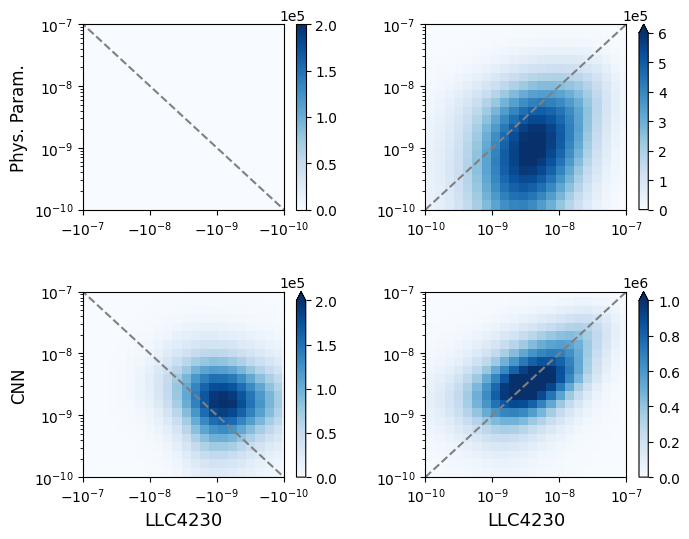

In [120]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(7,5.5))
fig.set_tight_layout(True)


ax = plt.subplot(2,2,1)
p = (xhist_param*0).plot(ax=ax, cmap='Blues',vmax=2e5,cbar_kwargs={'label': ""})
ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-10)
ax.set_yscale('log')
ax.set_ylim([1e-10,1e-7])
ax.set_xlim([-1e-7,-1e-10])
ax.set_xlabel(r" ", fontsize=13)
ax.set_ylabel(r"Phys. Param.", 
              fontsize=12)

p.colorbar.formatter.set_powerlimits((0, 0))
p.colorbar.update_ticks()


ax = plt.subplot(2,2,2)
p = xhist_param.plot(ax=ax, cmap='Blues',vmax=6e5,cbar_kwargs={'label': ""})
ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-10)
ax.set_yscale('log')
ax.set_ylim([1e-10,1e-7])
ax.set_xlim([1e-10,1e-7])
#ax.set_xlabel(r"LLC4230", fontsize=13)
#ax.set_ylabel(r"MLE Parameterization", 
#              fontsize=13)
ax.set_xlabel(r" ", fontsize=13)
ax.set_ylabel(r" ", 
              fontsize=12)
p.colorbar.formatter.set_powerlimits((0, 0))
p.colorbar.update_ticks()


ax = plt.subplot(2,2,3)
p = xhist_cnn.plot(ax=ax, cmap='Blues',vmax=2e5,cbar_kwargs={'label': ""})
ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-10)
ax.set_yscale('log')
ax.set_ylim([1e-10,1e-7])
ax.set_xlim([-1e-7,-1e-10])
#ax.set_xlabel(r"LLC4230", fontsize=13)
#ax.set_ylabel(r"MLE Parameterization", 
#              fontsize=13)
ax.set_xlabel(r"LLC4230", fontsize=13)
ax.set_ylabel(r"CNN", 
              fontsize=12)
p.colorbar.formatter.set_powerlimits((0, 0))
p.colorbar.update_ticks()


ax = plt.subplot(2,2,4)
p = xhist_cnn.plot(ax=ax, cmap='Blues',vmax=1e6,cbar_kwargs={'label': ""})
ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-10)
ax.set_yscale('log')
ax.set_ylim([1e-10,1e-7])
ax.set_xlim([1e-10,1e-7])
#ax.set_xlabel(r"LLC4230", fontsize=13)
#ax.set_ylabel(r"MLE Parameterization", 
#              fontsize=13)
ax.set_xlabel(r"LLC4230", fontsize=13)
ax.set_ylabel(r"", 
              fontsize=12)
p.colorbar.formatter.set_powerlimits((0, 0))
p.colorbar.update_ticks()



plt.savefig('./figures/pdfs_new')

In [ ]:
from xhistogram.xarray import histogram as xhist

fig, ax = plt.subplots(figsize=(6,4))
fig.set_tight_layout(True)

xhist(WB_param_xr, 
      bins=[np.concatenate((-np.logspace(-6,-11,30),
                            np.concatenate((np.linspace(-9e-12,9e-12,5),
                                            np.logspace(-11,-4,30)))))
           ]
     ).plot(ax=ax, label=r"Param")
xhist(WB_sg, 
      bins=[np.concatenate((-np.logspace(-6,-11,30),
                            np.concatenate((np.linspace(-9e-12,9e-12,5),
                                            np.logspace(-11,-4,30)))))
           ]
     ).plot(ax=ax, label=r"LLC4230")
xhist(WB_cnn_xr, 
      bins=[np.concatenate((-np.logspace(-6,-11,30),
                            np.concatenate((np.linspace(-9e-12,9e-12,5),
                                            np.logspace(-11,-4,30)))))
           ]
     ).plot(ax=ax, label='CNN')
ax.set_xscale('symlog', linthresh=1e-11)
#ax.set_xlabel(r"[m$^2$ s$^{-3}$]", fontsize=13)
ax.legend(loc='upper left', fontsize=12)
#plt.savefig(op.join(sdir,'Figs/eNATL60-wb-1Dhist_region%02d.pdf' % reg))


In [ ]:
fig, ax = plt.subplots(figsize=(6,3))
fig.set_tight_layout(True)

xhist_Bodner23.plot(ax=ax, cmap='Blues')

ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-10)
ax.set_yscale('log')
ax.set_ylim([1e-10,1e-6])
ax.set_xlim([-1e-6,1e-6])
ax.set_xlabel(r"$\overline{wb}^z-\overline{w}^z\overline{b}^z$", fontsize=13)
ax.set_ylabel(r"$\Psi^{\tt Bod}\times\overline{\langle b^m}^z$", 
              fontsize=13)

#plt.savefig(op.join(sdir,'Figs/eNATL60-wb_medianCr-hist_region%02d.pdf' % reg))

In [53]:
WB_param_Lf_FK_loc_mean.shape

(12, 2030)

In [10]:
lat_rad = np.empty(12)
PATH_LIST = glob.glob(BASE+'*_smooth/preprcossed_data/lat.nc')
i_lat_path = 0


for i_lat in range(12):
    #if i_lat == 1 or i_lat ==10 or i_lat ==11:
    #    lat_rad[i_lat] = np.NaN
    #else:
    #    print(i_lat_path)
        lat_rad[i_lat] = xr.open_dataarray(PATH_LIST[i_lat]).values.mean()
    #    i_lat_path = i_lat_path+1
    
    
lat_rad_sorted = np.sort(lat_rad)[::-1]
lat_ind_sorted = np.argsort(lat_rad)[::-1]

In [13]:
WB_sg_loc_mean_sorted = WB_sg_loc_mean#[lat_ind_sorted,:]
WB_param_loc_mean_sorted = WB_param_loc_mean#[lat_ind_sorted,:]
WB_cnn_loc_mean_sorted = WB_cnn_loc_mean#[lat_ind_sorted,:]

NameError: name 'WB_sg_loc_mean' is not defined

In [12]:
# monthly averages 

WB_sg_loc_time_mean = np.empty((12,12))
WB_param_loc_time_mean = np.empty((12,12))
WB_cnn_loc_time_mean = np.empty((12,12))
WB_param_Lf_BD_loc_time_mean = np.empty((12,12))
WB_param_Lf_FK_loc_time_mean = np.empty((12,12))

for i_loc in range(12):
    for i_month in range(12):
        WB_sg_loc_time_mean[i_loc,i_month] = np.mean(WB_sg_loc_mean_sorted[i_loc,~np.isnan(WB_sg_loc_mean[i_loc])][location_month_index_loc[i_loc,~np.isnan(location_month_index_loc[i_loc])]==i_month])
        WB_param_loc_time_mean[i_loc,i_month] = np.mean(WB_param_loc_mean_sorted[i_loc,~np.isnan(WB_param_loc_mean[i_loc])][location_month_index_loc[i_loc,~np.isnan(location_month_index_loc[i_loc])]==i_month])
        WB_cnn_loc_time_mean[i_loc,i_month] = np.mean(WB_cnn_loc_mean_sorted[i_loc,~np.isnan(WB_cnn_loc_mean[i_loc])][location_month_index_loc[i_loc,~np.isnan(location_month_index_loc[i_loc])]==i_month])
        #WB_param_Lf_BD_loc_time_mean[i_loc,i_month] = np.mean(WB_param_Lf_BD_loc_mean[i_loc,~np.isnan(WB_param_Lf_BD_loc_mean[i_loc])][location_month_index_loc[i_loc,~np.isnan(location_month_index_loc[i_loc])]==i_month])
        #WB_param_Lf_FK_loc_time_mean[i_loc,i_month] = np.mean(WB_param_Lf_FK_loc_mean[i_loc,~np.isnan(WB_param_Lf_FK_loc_mean[i_loc])][location_month_index_loc[i_loc,~np.isnan(location_month_index_loc[i_loc])]==i_month])
        

NameError: name 'WB_sg_loc_mean_sorted' is not defined

In [31]:
baseline_mse_1_4 =  np.mean((WB_sg_loc_time_mean.flatten() - WB_sg_loc_time_mean.mean()) ** 2)


In [32]:
r2_1_4_loc = np.empty((12,1))
r2_1_4_loc[:] = np.nan



for i_loc in range(12):
    
    #prediction_1_4_loc = prediction_1_4[submeso_dataset.location_ind[submeso_dataset.test_ind]==i_loc]
    #target_1_4_loc = target_1_4[submeso_dataset.location_ind[submeso_dataset.test_ind]==i_loc]
    #WB_param_1_4_loc = WB_FK08_param_1_4[submeso_dataset.location_ind[submeso_dataset.test_ind]==i_loc]
    r2_1_4_loc[i_loc] = 1 - mean_squared_error(WB_sg_loc_time_mean[i_loc],WB_cnn_loc_time_mean[i_loc])/baseline_mse_1_4


In [2]:
r2_1_4_loc

NameError: name 'r2_1_4_loc' is not defined

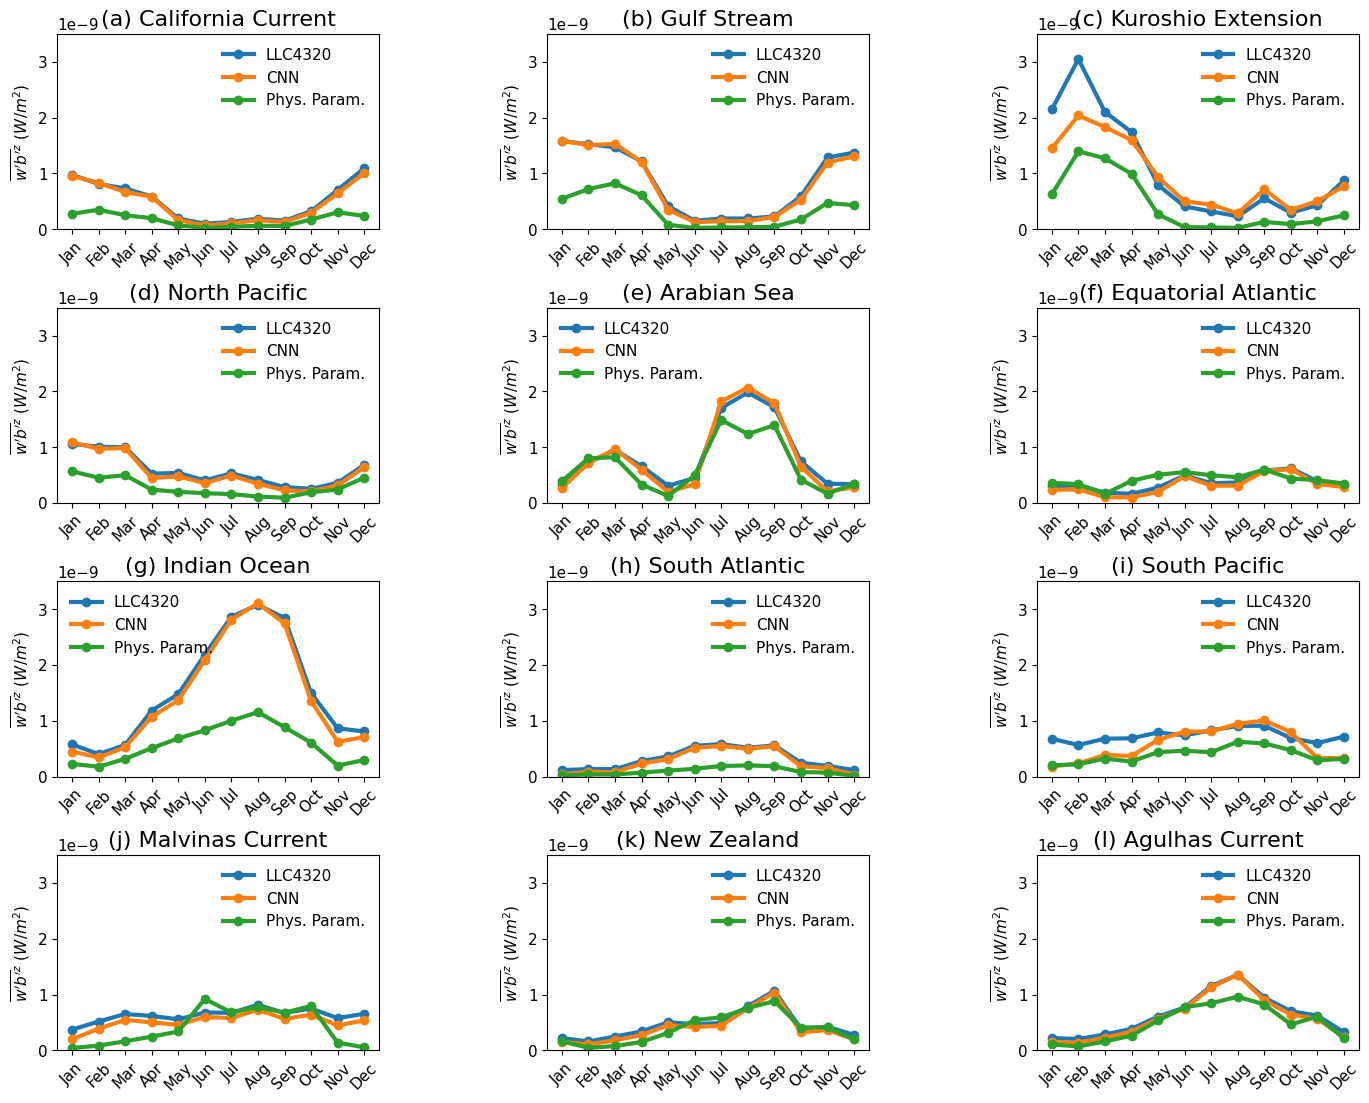

In [38]:
fig, axes = plt.subplots(nrows=3, ncols=4,figsize=(15,12))
fig.tight_layout(pad=5.0)
plt.rcParams.update({'font.size': 11})
fig.tight_layout(pad=5.0)
abc_list = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)']
for ii in range(12):
        i_loc = lat_ind_sorted[ii]
        ax = plt.subplot(4,3,ii+1)
        my_xticks = [ 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep', 'Oct','Nov','Dec',]
        plt.xticks(np.arange(0,12,1), my_xticks,rotation = 45); 
        if i_loc==0 or 3 or 6:
            plt.ylabel(r'$\overline{w^\prime b^\prime}^z\ (W/m^2)$')
            
        plt.plot(np.roll(WB_sg_loc_time_mean[i_loc],-3),'o-',linewidth=3,label='LLC4320')
        plt.plot(np.roll(WB_cnn_loc_time_mean[i_loc],-3),'o-',linewidth=3,label='CNN')
        plt.plot(np.roll(WB_param_loc_time_mean[i_loc],-3),'o-',linewidth=3,label='Phys. Param.')
        #plt.plot(np.roll(WB_param_Lf_FK_loc_mean[i_loc],-4),'o-',linewidth=2,label='Lf FK')
        #plt.plot(np.roll(WB_param_Lf_BD_loc_time_mean[i_loc],-4),'o-',linewidth=2,label='Lf BD')
        
        plt.title(abc_list[ii]+' '+label_list[i_loc],fontsize=16)
        #if i_loc==0:
        plt.ylim([0,3.5e-9])
        plt.legend().get_frame().set_alpha(0)
        


#plt.savefig('./figures/timeseries')
plt.savefig('./figures/timeseries_cnn', transparent=True)


In [16]:
mse_param = np.empty(10)
mse_cnn = np.empty(10)
r2_param = np.empty(10)
r2_cnn = np.empty(10)
corr_param = np.empty(10)
corr_cnn = np.empty(10)


for i_loc in range(10):
    WB_param_norm = (WB_param_loc_time_mean[i_loc] - WB_sg_mean_test_loc[i_loc])/WB_sg_std_test_loc[i_loc]
    WB_cnn_norm = (WB_cnn_loc_time_mean[i_loc] - WB_sg_mean_test_loc[i_loc])/WB_sg_std_test_loc[i_loc]
    WB_sg_norm = (WB_sg_loc_time_mean[i_loc] - WB_sg_mean_test_loc[i_loc])/WB_sg_std_test_loc[i_loc]
    
    mse_param[i_loc] = np.sqrt(mean_squared_error(WB_param_norm,WB_sg_norm))
    mse_cnn[i_loc] = np.sqrt(mean_squared_error(WB_cnn_norm,WB_sg_norm))

    r2_param[i_loc] = r2_score(WB_param_loc_time_mean[i_loc],WB_sg_loc_time_mean[i_loc])
    r2_cnn[i_loc] = r2_score(WB_cnn_loc_time_mean[i_loc],WB_sg_loc_time_mean[i_loc])

    corr_param[i_loc], _ = pearsonr(WB_param_loc_time_mean[i_loc],WB_sg_loc_time_mean[i_loc])
    corr_cnn[i_loc], _ = pearsonr(WB_cnn_loc_time_mean[i_loc],WB_sg_loc_time_mean[i_loc])
    

ValueError: Input contains NaN.

In [ ]:
plt.plot(WB_cnn_loc_time_mean[1])
plt.plot(WB_sg_loc_time_mean[1])

In [ ]:
plt.plot(mse_param)
plt.plot(mse_cnn)

In [ ]:
mse_param

In [ ]:
mse_cnn

In [ ]:
!pip install ternary

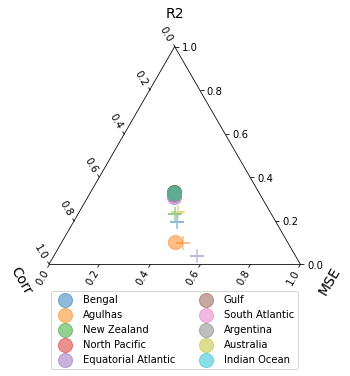

In [441]:
import ternary
from matplotlib.pyplot import cm

# Create a ternary plot
ax = plt.subplot(projection="ternary")

# Plot the triangle scatter plot
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    ax.scatter(r2_cnn[i_loc],corr_cnn[i_loc], 1-mse_cnn[i_loc],marker='o',color=c_loc,s=200,alpha=0.5)
    #plt.legend(label_list,ncol=2,loc='lower right', fontsize=9)
ax.set_tlabel("R2",size=14)
ax.set_llabel("Corr",size=14)
ax.set_rlabel("MSE",size=14)
ax.legend(label_list,ncol=2,bbox_to_anchor=(0.5, -.1), loc='upper center')
for i_loc, c_loc in zip(range(10),color):
    ax.scatter(r2_param[i_loc],corr_param[i_loc], 1-mse_param[i_loc],marker='+',color=c_loc,s=200,alpha=0.5)
plt.show()

In [443]:
1-mse_param

array([0.96670706, 0.94860386, 0.96247289, 0.92543173, 0.95936406,
       0.9221934 , 0.91973693, 0.93642202, 0.96082927, 0.91505238])

In [352]:
mse_cnn[0]

1.7380944050007118e-20

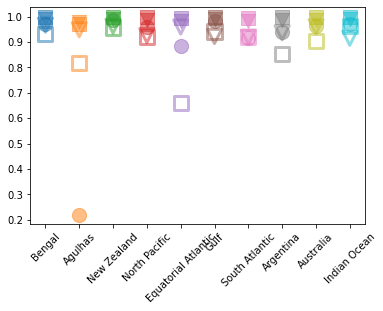

In [469]:
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    #ax.scatter(r2_cnn[i_loc],corr_cnn[i_loc], 1-mse_cnn[i_loc],marker='o',color=c_loc,s=200,alpha=0.5)

    my_xticks = label_list
    plt.xticks(np.arange(10), my_xticks,rotation = 45);
    plt.scatter(i_loc,r2_cnn[i_loc],marker='o',color=c_loc,s=200,alpha=0.5)
    plt.scatter(i_loc,corr_cnn[i_loc],marker='s',color=c_loc,s=200,alpha=0.5)
    plt.scatter(i_loc,1-mse_cnn[i_loc],marker='v',color=c_loc,s=200,alpha=0.5)
    
    #plt.scatter(i_loc,r2_param[i_loc],marker='o',facecolors=None,edgecolors=c_loc,s=200,alpha=0.5)
    plt.scatter(i_loc,corr_param[i_loc],marker='s',facecolors='none',edgecolors=c_loc,linewidth=3,s=200,alpha=0.5)
    plt.scatter(i_loc,1-mse_param[i_loc],marker='v',facecolors='none',edgecolors=c_loc,linewidth=3,s=200,alpha=0.5)


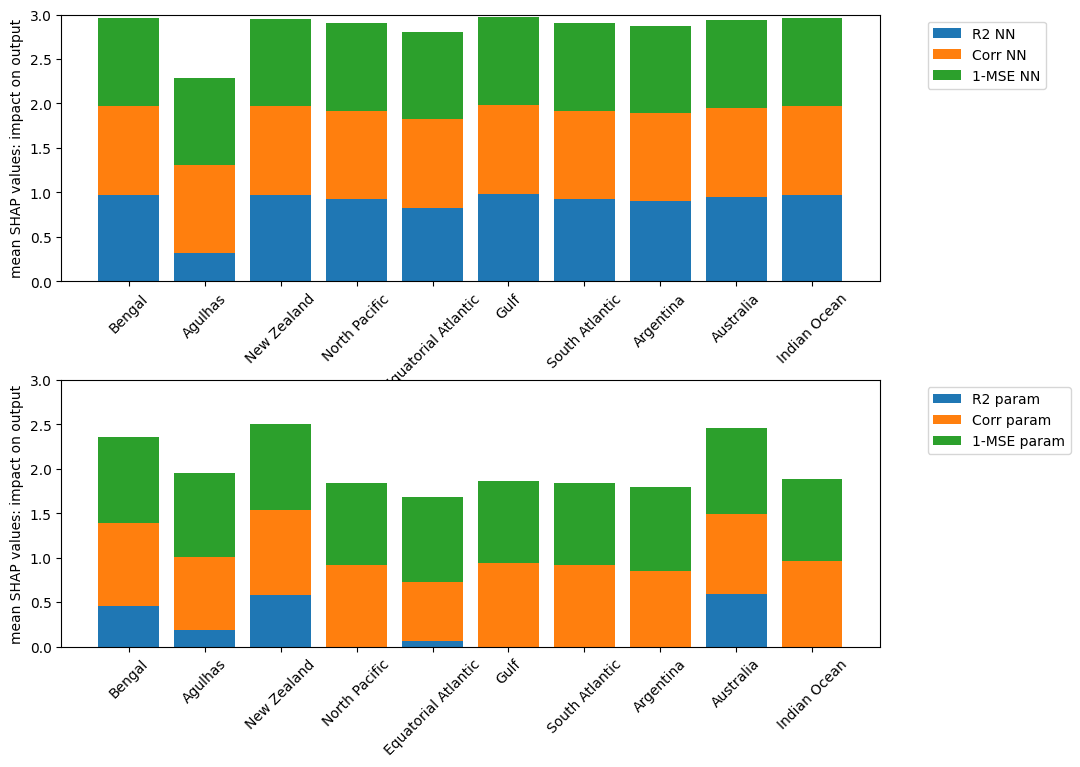

In [65]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(10,8))
fig.tight_layout(pad=5.0)

plt.subplot(2,1,1)
plt.bar(label_list,r2_cnn,label='R2 NN')
plt.bar(label_list,corr_cnn,bottom=r2_cnn,label='Corr NN')
plt.bar(label_list,1-mse_cnn,bottom=r2_cnn+corr_cnn,label='1-MSE NN')
my_xticks = label_list
plt.xticks(np.arange(10), my_xticks,rotation = 45);
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.ylabel('mean SHAP values: impact on output')
plt.ylim([0,3])

plt.subplot(2,1,2)
plt.bar(label_list,r2_param,label='R2 param')
plt.bar(label_list,corr_param,bottom=r2_param,label='Corr param')
plt.bar(label_list,1-mse_param,bottom=r2_param+corr_param,label='1-MSE param')
my_xticks = label_list
plt.xticks(np.arange(10), my_xticks,rotation = 45);
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.ylabel('mean SHAP values: impact on output')
plt.ylim([0,3])

plt.savefig('./figures/r2_corr_mse')


(0.0, 1.1)

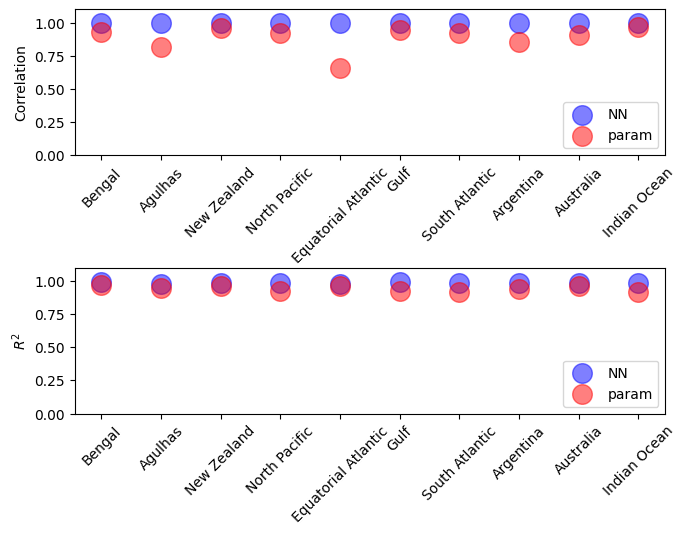

In [162]:
from matplotlib.pyplot import cm

fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(8,6))
fig.tight_layout(pad=6.0)

plt.subplot(2,1,1)
plt.scatter(label_list,corr_cnn, color='b',marker='o',s=200,alpha=0.5,label='NN')
plt.scatter(label_list,corr_param, color='r',marker='o',s=200,alpha=0.5,label='param')
#plt.scatter(label_list,1-mse_cnn,color='g',s=200,alpha=0.5, label='1-MSE NN')
my_xticks = label_list
plt.xticks(np.arange(10), my_xticks,rotation = 45);
plt.legend(fontsize=10, loc='lower right')
plt.ylabel('Correlation')
plt.ylim([0,1.1])

plt.subplot(2,1,2)
plt.scatter(label_list,1-mse_cnn,color='b',s=200,alpha=0.5,label='NN')
plt.scatter(label_list,1-mse_param,color='r',s=200,alpha=0.5,label='param')
my_xticks = label_list
plt.xticks(np.arange(10), my_xticks,rotation = 45,fontsize=10);
plt.legend(fontsize=10, loc='lower right')
plt.ylabel(r'$R^2$')
plt.ylim([0,1.1])

#plt.savefig('./figures/r2_corr')


In [ ]:

    
    
    if i_loc<10:
        ax = plt.subplot(3,4,i_loc+1)
        my_xticks = [ 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep', 'Oct','Nov','Dec',]
        plt.xticks(np.arange(0,12,1), my_xticks,rotation = 45); 
        if i_loc==0 or 3 or 6:
            plt.ylabel('Submesoscale fluxes')
        plt.plot(np.roll(WB_sg_loc_time_mean[i_loc],-4),'o-',linewidth=2,label='LLC4320')
        plt.plot(np.roll(WB_cnn_loc_time_mean[i_loc],-4),'o-',linewidth=2,label='CNN')
        plt.plot(np.roll(WB_param_loc_time_mean[i_loc],-4),'o-',linewidth=2,label='Param')
        
        plt.title(label_list[i_loc])
        #if i_loc==0:
        plt.ylim([0,5e-9])
        plt.legend()
        #corr_loc[i_loc]
    else:
        ax = plt.subplot(3,4,i_loc+1)
        my_xticks = ['Sep', 'Oct','Nov','Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep', 'Oct','Nov']
        plt.xticks(np.arange(0,100,100/15), my_xticks,rotation = 45);               
        WB_sg_loc_mean_plot = np.nan
        WB_cnn_loc_mean_plot = np.nan
        WB_param_loc_mean_plot = np.nan

        plt.ylabel('Submesoscale fluxes')
        plt.plot(WB_sg_loc_mean_plot,'-',linewidth=2,label='LLC4320')
        plt.plot(WB_cnn_loc_mean_plot,'-',linewidth=2,label='CNN')
        plt.plot(WB_param_loc_mean_plot,'-',linewidth=2,label='Param')
        #plt.title(label_list[i_loc])
        #if i_loc==0:
        plt.ylim([0,5e-9])
        plt.legend()
        #corr_loc[i_loc]
        

plt.savefig('./figures/fcnn/timeseries')

# locations

In [ ]:
location_test = location_index[test_ind]

# renormalize using mean and std 
WB_sg_mean_test = WB_sg_mean[test_ind]
WB_sg_std_test = WB_sg_std[test_ind] 

mean_tile = np.transpose(np.tile(WB_sg_mean_test,(40,40,1,1)))
std_tile = np.transpose(np.tile(WB_sg_std_test,(40,40,1,1)))

WB_cnn = np.squeeze((cnn_submeso(b_x.to(device)).detach().cpu().numpy()*std_tile + mean_tile))

WB_sg = np.squeeze(xr.DataArray((b_y.detach().cpu().numpy()*std_tile + mean_tile)))

WB_cnn_loc = np.empty((10,846,40,40))
WB_cnn_loc[:] = np.nan
WB_cnn_loc_flat = np.empty((10,846*40*40))

WB_sg_loc = np.empty((10,846,40,40))
WB_sg_loc[:] = np.nan
WB_sg_loc_flat = np.empty((10,846*40*40))

# renormalize to physical space

Q_mean_test_tile = np.transpose(np.tile(Q_mean[test_ind],(40,40,1)))
Q_std_test_tile = np.transpose(np.tile(Q_std[test_ind],(40,40,1)))
Q_phys = Q[test_ind]*Q_std_test_tile + Q_mean_test_tile

TAU_mean_test_tile = np.transpose(np.tile(TAU_mean[test_ind],(40,40,1)))
TAU_std_test_tile = np.transpose(np.tile(TAU_std[test_ind],(40,40,1)))
TAU_phys = TAU[test_ind]*TAU_std_test_tile + TAU_mean_test_tile

grad_B_mean_test_tile = np.transpose(np.tile(grad_B_mean[test_ind],(40,40,1)))
grad_B_std_test_tile = np.transpose(np.tile(grad_B_std[test_ind],(40,40,1)))
grad_B_phys = grad_B[test_ind]*grad_B_std_test_tile + grad_B_mean_test_tile

Q_loc = np.empty((10,846,40,40))
TAU_loc = np.empty((10,846,40,40))
grad_B_loc = np.empty((10,846,40,40))

WB_sg_loc_mean = np.empty((10,1))
WB_cnn_loc_mean = np.empty((10,1))
Q_loc_mean = np.empty((10,1))
TAU_loc_mean = np.empty((10,1))
grad_B_loc_mean = np.empty((10,1))
i_max_loc = np.empty((10,1))

# cell size 
drF_test = drF[test_ind] 
drF_test_loc = np.empty((10,846,40,40))
drF_test_loc[:] = np.nan

for i_loc in range(10):
    drF_test_loc[i_loc,location_index[test_ind]==i_loc,:,:] = drF_test[location_index[test_ind]==i_loc]
    
    WB_cnn_loc[i_loc,location_index[test_ind]==i_loc,:,:] = WB_cnn[location_index[test_ind]==i_loc]
    WB_cnn_loc_flat[i_loc,:]  = WB_cnn_loc[i_loc].flatten()
    WB_cnn_loc_mean[i_loc] = np.nanmax((np.squeeze(np.apply_over_axes(np.sum, WB_cnn_loc[i_loc]*WB_cnn_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)
    i_max_loc[i_loc] = np.argmax((np.squeeze(np.apply_over_axes(np.nansum, WB_cnn_loc[i_loc]*WB_cnn_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)

    
    WB_sg_loc[i_loc,location_index[test_ind]==i_loc,:,:] = WB_sg[location_index[test_ind]==i_loc]
    WB_sg_loc_flat[i_loc,:]  = WB_sg_loc[i_loc].flatten()
    WB_sg_loc_mean[i_loc] = ((np.squeeze(np.apply_over_axes(np.sum, WB_sg_loc[i_loc]*WB_sg_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)[int(i_max_loc[i_loc])]
    
    
    Q_loc[i_loc,location_index[test_ind]==i_loc,:,:] = Q_phys[location_index[test_ind]==i_loc]
    Q_loc_mean[i_loc] = ((np.squeeze(np.apply_over_axes(np.sum, Q_loc[i_loc]*Q_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)[int(i_max_loc[i_loc])]
    
    TAU_loc[i_loc,location_index[test_ind]==i_loc,:,:] = TAU_phys[location_index[test_ind]==i_loc]
    TAU_loc_mean[i_loc] = ((np.squeeze(np.apply_over_axes(np.sum, TAU_loc[i_loc]*TAU_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)[int(i_max_loc[i_loc])]
    
    grad_B_loc[i_loc,location_index[test_ind]==i_loc,:,:] = grad_B_phys[location_index[test_ind]==i_loc]
    grad_B_loc_mean[i_loc] = ((np.squeeze(np.apply_over_axes(np.sum, grad_B_loc[i_loc]*grad_B_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)[int(i_max_loc[i_loc])]
    

## magnitude

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(8,12))
fig.set_tight_layout(True)

ax = plt.subplot(3,1,1)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(Q_loc_mean[i_loc],WB_cnn_loc_mean[i_loc],color=c_loc,s=100+3*jacobian_loc[i_loc,0],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(Q_loc_mean[i_loc],WB_cnn_loc_mean[i_loc],color='k',s=10,marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(Q_loc_mean[i_loc]*np.nan, WB_sg_loc_mean[i_loc],color=c_loc,s=100,marker='o',alpha=0.5)
    plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
plt.ylabel('WB cnn mag')
plt.xlabel('Q mag')
    
ax = plt.subplot(3,1,2)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(TAU_loc_mean[i_loc],WB_cnn_loc_mean[i_loc],color=c_loc,s=100+3*jacobian_loc[i_loc,1],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(TAU_loc_mean[i_loc],WB_cnn_loc_mean[i_loc],color='k',s=10,marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(TAU_loc_mean[i_loc]*np.nan,WB_sg_loc_mean[i_loc],color=c_loc,s=100,marker='o',alpha=0.5)
    plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
plt.ylabel('WB cnn mag')
plt.xlabel('TAU mag')

ax = plt.subplot(3,1,3)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(grad_B_loc_mean[i_loc],WB_cnn_loc_mean[i_loc],color=c_loc,s=100+3*jacobian_loc[i_loc,2],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(grad_B_loc_mean[i_loc],WB_cnn_loc_mean[i_loc],color='k',s=10,marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(grad_B_loc_mean[i_loc]*np.nan,WB_sg_loc_mean[i_loc],color=c_loc,s=100,marker='o',alpha=0.5)
    plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
plt.ylabel('WB cnn mag')
plt.xlabel('grad B mag')

plt.savefig('./figures/cnn_7l_k5_surface_inputs_magnitude_Jacobian')


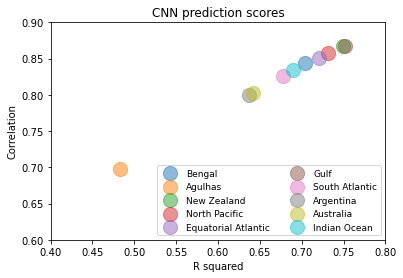

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(6,4))

from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(r2score_loc[i_loc],corr_loc[i_loc],color=c_loc,s=200,alpha=0.5)
    plt.xlim([0.4,.8])
    plt.ylim([0.6,.9])
    #plt.legend(label_list)
    plt.legend(label_list,ncol=2,loc='lower right', fontsize=9)
plt.xlabel('R squared')
plt.ylabel('Correlation')
plt.title('CNN prediction scores')
plt.savefig('./figures/cnn_7l_k5_surface_inputs_R2_corr_scores')

In [ ]:
r2score_loc

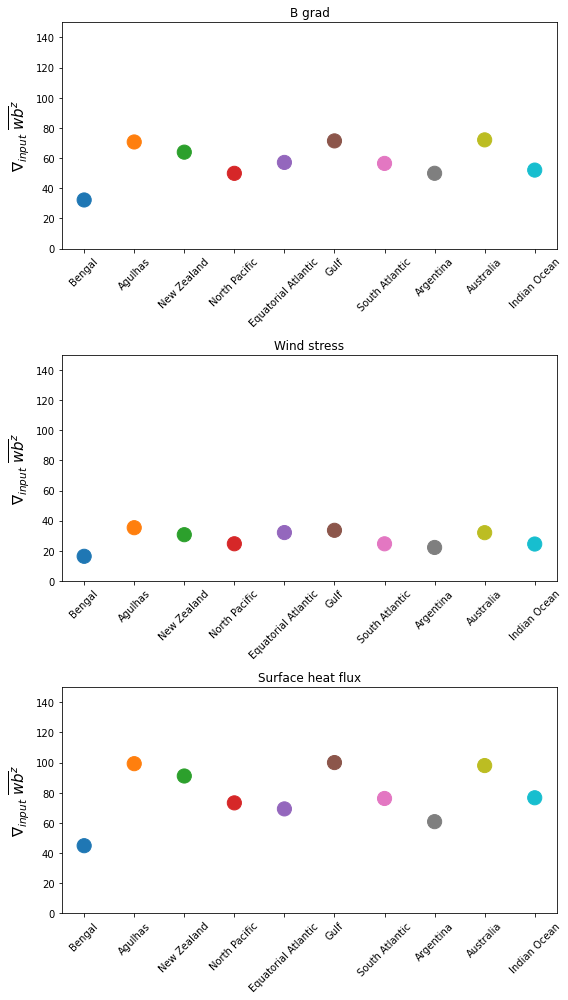

In [31]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(8,14))
fig.set_tight_layout(True)

ax = plt.subplot(3,1,1)
plt.scatter(np.arange(10),jacobian_loc[:,0],c=range(10),s=200,cmap='tab10')
my_xticks = label_list
plt.xticks(np.arange(10), my_xticks,rotation = 45);
plt.title('B grad')
plt.ylim([0,150])
plt.ylabel(r'$\nabla_{input}\ \overline{wb}^z}$',fontsize=15)

ax = plt.subplot(3,1,2)
plt.scatter(np.arange(10),jacobian_loc[:,1],c=range(10),s=200,cmap='tab10')
my_xticks = label_list
plt.xticks(np.arange(10), my_xticks,rotation = 45);
plt.title('Wind stress')
plt.ylim([0,150])
plt.ylabel(r'$\nabla_{input}\ \overline{wb}^z}$',fontsize=15)

ax = plt.subplot(3,1,3)
plt.scatter(np.arange(10),jacobian_loc[:,2],c=range(10),s=200,cmap='tab10')
my_xticks = label_list
plt.xticks(np.arange(10), my_xticks,rotation = 45);
plt.title('Surface heat flux')
plt.ylabel(r'$\nabla_{input}\ \overline{wb}^z}$',fontsize=15)
plt.ylim([0,150])
plt.savefig('./figures/cnn_7l_k5_surface_inputs_Jacobian')

# Regional statistics

## positive fluxes

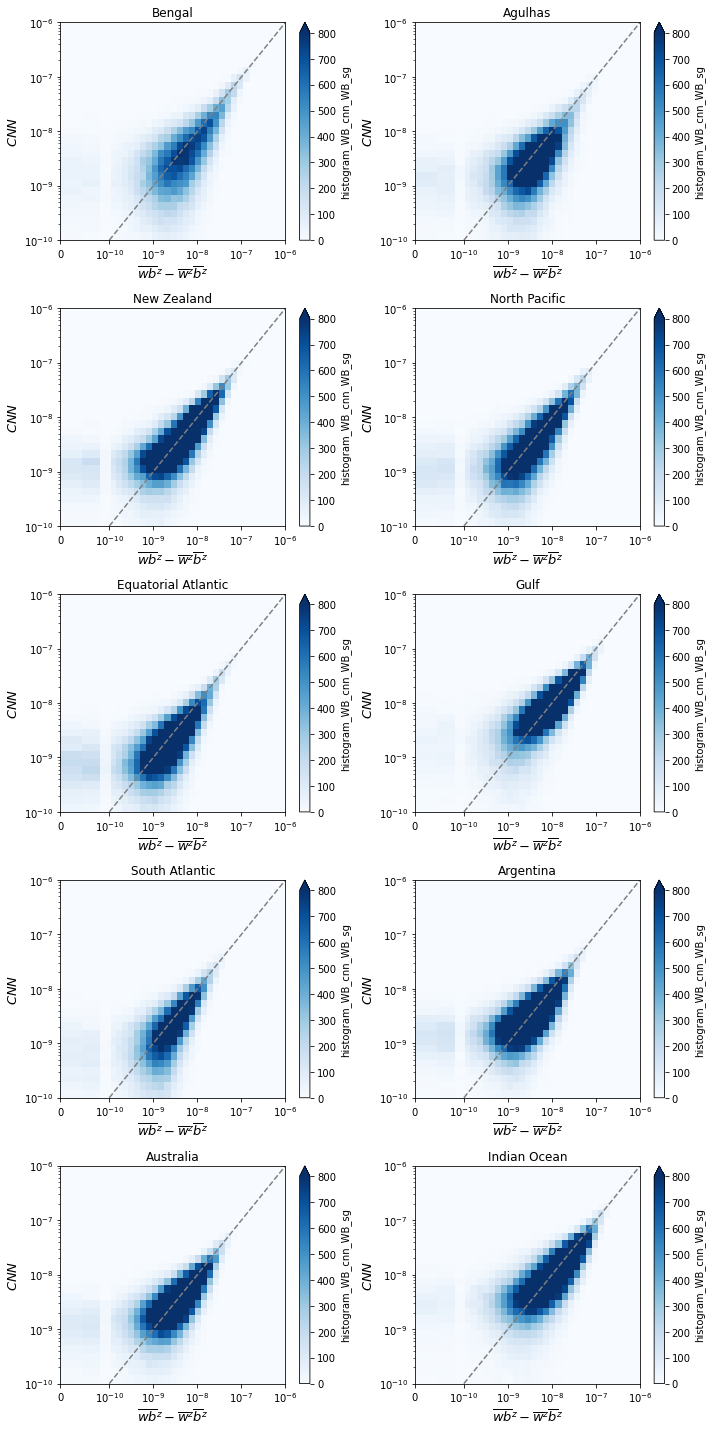

In [32]:
import matplotlib as mpl
from xhistogram.xarray import histogram as xhist

fig, axes = plt.subplots(nrows=5, ncols=2,figsize=(10,20))
fig.set_tight_layout(True)

i_plot=0

for i_loc in range(10):
    
    WB_cnn  = xr.DataArray(WB_cnn_loc_flat[i_loc,:])
    WB_cnn.name = 'WB_cnn'
    WB_sg  = xr.DataArray(WB_sg_loc_flat[i_loc,:])
    WB_sg.name = 'WB_sg'

    xhist_CNN = xhist(WB_cnn, 
      WB_sg,
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),
                                            np.logspace(-10,-6,30)))))
           ]
     ).compute()
    

    ax = plt.subplot(5,2,i_loc+1)
    xhist_CNN.plot(vmax=800, cmap='Blues')
    ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
    ax.set_xscale('symlog', linthresh=1e-10)
    ax.set_yscale('log')
    ax.set_ylim([1e-10,1e-6])
    ax.set_xlim([0,1e-6])
    ax.set_xlabel(r"$\overline{wb}^z-\overline{w}^z\overline{b}^z$", fontsize=13)
    ax.set_ylabel(r"$CNN$", 
                  fontsize=13)
    plt.title(label_list[i_loc])


plt.savefig('./figures/cnn_7l_k5_surface_inputs_all_positive_fluxes')

## negative fluxes

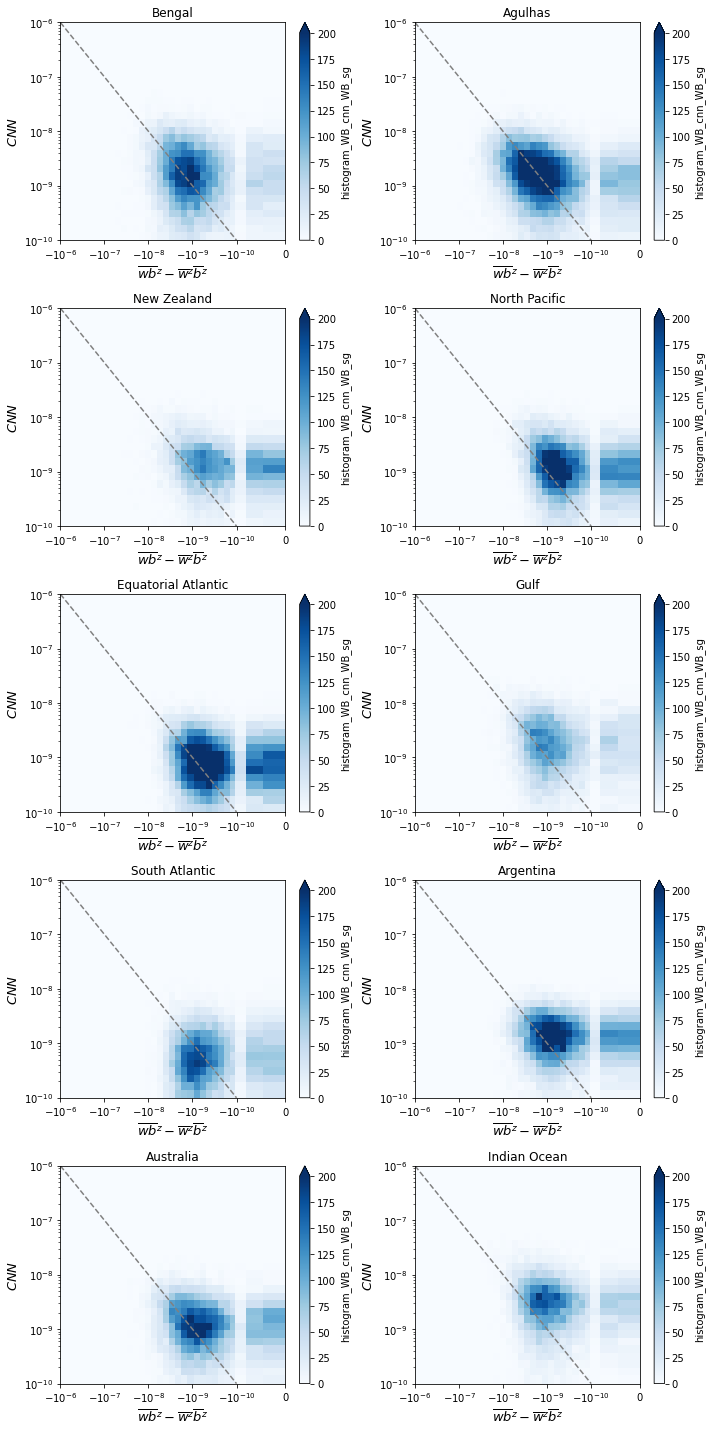

In [33]:
import matplotlib as mpl
from xhistogram.xarray import histogram as xhist

fig, axes = plt.subplots(nrows=5, ncols=2,figsize=(10,20))
fig.set_tight_layout(True)

i_plot=0

for i_loc in range(10):
    
    WB_cnn  = xr.DataArray(WB_cnn_loc_flat[i_loc,:])
    WB_cnn.name = 'WB_cnn'
    WB_sg  = xr.DataArray(WB_sg_loc_flat[i_loc,:])
    WB_sg.name = 'WB_sg'

    xhist_CNN = xhist(WB_cnn, 
      WB_sg,
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),
                                            np.logspace(-10,-6,30)))))
           ]
     ).compute()
    ax = plt.subplot(5,2,i_loc+1)
    xhist_CNN.plot(vmax=200, cmap='Blues')
    ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
    ax.set_xscale('symlog', linthresh=1e-10)
    ax.set_yscale('log')
    ax.set_ylim([1e-10,1e-6])
    ax.set_xlim([-1e-6,0])
    ax.set_xlabel(r"$\overline{wb}^z-\overline{w}^z\overline{b}^z$", fontsize=13)
    ax.set_ylabel(r"$CNN$", 
                  fontsize=13)
    plt.title(label_list[i_loc])


plt.savefig('./figures/cnn_7l_k5_surface_inputs_all_negative_fluxes')

# Seasonality - JFM


In [34]:
# build test loader for JFM and JAS
b_x_JFM, b_y_JFM, prediction_JFM = plot_model_direct(cnn_submeso, criterion, loader_test_JFM,len(torch_dataset_test_JFM))

Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.26056235255185894


In [35]:
jacobian_JFM = Jacobian_norm(b_x,prediction)

Text(0, 0.5, '$\\nabla_{input}\\ \\overline{wb}^z}$')

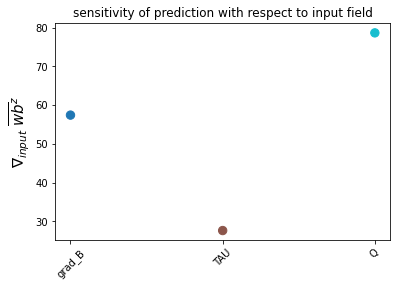

In [36]:
plt.scatter(np.arange(3),jacobian_JFM.detach(),c=range(3),s=70,cmap='tab10')
my_xticks = ['grad_B','TAU', 'Q']
plt.xticks(np.arange(3), my_xticks,rotation = 45);
plt.title('sensitivity of prediction with respect to input field')
plt.ylabel(r'$\nabla_{input}\ \overline{wb}^z}$',fontsize=15)

In [76]:
# renormalize using mean and std 
WB_sg_mean_test = WB_sg_mean[JFM_test_ind]
WB_sg_std_test = WB_sg_std[JFM_test_ind] 

mean_tile = np.transpose(np.tile(WB_sg_mean_test,(40,40,1,1)))
std_tile = np.transpose(np.tile(WB_sg_std_test,(40,40,1,1)))

WB_cnn_JFM = np.squeeze((cnn_submeso(b_x_JFM.to(device)).detach().cpu().numpy()*std_tile + mean_tile))

WB_sg_JFM = np.squeeze(xr.DataArray((b_y_JFM.detach().cpu().numpy()*std_tile + mean_tile)))

WB_cnn_loc = np.empty((10,len(JFM_test_ind),40,40))
WB_cnn_loc[:] = np.nan
WB_cnn_loc_flat = np.empty((10,len(JFM_test_ind)*40*40))

WB_sg_loc = np.empty((10,len(JFM_test_ind),40,40))
WB_sg_loc[:] = np.nan
WB_sg_loc_flat = np.empty((10,len(JFM_test_ind)*40*40))

# renormalize to physical space

Q_mean_test_tile = np.transpose(np.tile(Q_mean[JFM_test_ind],(40,40,1)))
Q_std_test_tile = np.transpose(np.tile(Q_std[JFM_test_ind],(40,40,1)))
Q_phys = Q[JFM_test_ind]*Q_std_test_tile + Q_mean_test_tile

TAU_mean_test_tile = np.transpose(np.tile(TAU_mean[JFM_test_ind],(40,40,1)))
TAU_std_test_tile = np.transpose(np.tile(TAU_std[JFM_test_ind],(40,40,1)))
TAU_phys = TAU[JFM_test_ind]*TAU_std_test_tile + TAU_mean_test_tile

grad_B_mean_test_tile = np.transpose(np.tile(grad_B_mean[JFM_test_ind],(40,40,1)))
grad_B_std_test_tile = np.transpose(np.tile(grad_B_std[JFM_test_ind],(40,40,1)))
grad_B_phys = grad_B[JFM_test_ind]*grad_B_std_test_tile + grad_B_mean_test_tile

Q_loc = np.empty((10,len(JFM_test_ind),40,40))
TAU_loc = np.empty((10,len(JFM_test_ind),40,40))
grad_B_loc = np.empty((10,len(JFM_test_ind),40,40))

WB_sg_loc_mean_JFM = np.empty((10,1))
WB_cnn_loc_mean_JFM = np.empty((10,1))
Q_loc_mean_JFM = np.empty((10,1))
TAU_loc_mean_JFM = np.empty((10,1))
grad_B_loc_mean_JFM = np.empty((10,1))
i_max_loc = np.empty((10,1))

# cell size 
drF_test_JFM = drF[JFM_test_ind] 
drF_test_loc = np.empty((10,len(JFM_test_ind),40,40))
drF_test_loc[:] = np.nan

for i_loc in range(10):
    drF_test_loc[i_loc,location_index[JFM_test_ind]==i_loc,:,:] = drF_test_JFM[location_index[JFM_test_ind]==i_loc]
    
    WB_cnn_loc[i_loc,location_index[JFM_test_ind]==i_loc,:,:] = WB_cnn_JFM[location_index[JFM_test_ind]==i_loc]
    WB_cnn_loc_flat[i_loc,:]  = WB_cnn_loc[i_loc].flatten()
    WB_cnn_loc_mean_JFM[i_loc] =  np.nanmax((np.squeeze(np.apply_over_axes(np.nansum, WB_cnn_loc[i_loc]*WB_cnn_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)
    i_max_loc[i_loc] = np.argmax((np.squeeze(np.apply_over_axes(np.nansum, WB_cnn_loc[i_loc]*WB_cnn_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)
    
    WB_sg_loc[i_loc,location_index[JFM_test_ind]==i_loc,:,:] = WB_sg_JFM[location_index[JFM_test_ind]==i_loc]
    WB_sg_loc_flat[i_loc,:]  = WB_sg_loc[i_loc].flatten()
    WB_sg_loc_mean_JFM[i_loc] =  ((np.squeeze(np.apply_over_axes(np.nansum, WB_sg_loc[i_loc]*WB_sg_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)[int(i_max_loc[i_loc])]
    
    Q_loc[i_loc,location_index[JFM_test_ind]==i_loc,:,:] = Q_phys[location_index[JFM_test_ind]==i_loc]
    Q_loc_mean_JFM[i_loc] =((np.squeeze(np.apply_over_axes(np.nansum, Q_loc[i_loc]*Q_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)[int(i_max_loc[i_loc])]
    
    TAU_loc[i_loc,location_index[JFM_test_ind]==i_loc,:,:] = TAU_phys[location_index[JFM_test_ind]==i_loc]
    TAU_loc_mean_JFM[i_loc] = ((np.squeeze(np.apply_over_axes(np.nansum, TAU_loc[i_loc]*TAU_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)[int(i_max_loc[i_loc])]
    
    grad_B_loc[i_loc,location_index[JFM_test_ind]==i_loc,:,:] = grad_B_phys[location_index[JFM_test_ind]==i_loc]
    grad_B_loc_mean_JFM[i_loc] = ((np.squeeze(np.apply_over_axes(np.nansum, grad_B_loc[i_loc]*grad_B_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)[int(i_max_loc[i_loc])]


In [38]:
# Jacobian per location JFM


r2score_loc_JFM = np.empty((10,1))
corr_loc_JFM = np.empty((10,1))
jacobian_loc_JFM = np.empty((10,3))

for i_loc in range(10):
    torch_dataset_test_loc = Data.TensorDataset(
        torch.from_numpy(X_input[JFM_test_ind[location_index[JFM_test_ind]==i_loc]]).double(),
        torch.from_numpy(Y_output[JFM_test_ind[location_index[JFM_test_ind]==i_loc]]).double(),    
    )

    BATCH_SIZE_TEST = len(torch_dataset_test_loc)

    loader_test_loc = Data.DataLoader(
        dataset=torch_dataset_test_loc, batch_size=BATCH_SIZE_TEST, shuffle=False
    )


    loader_test_loc
    b_x_loc, b_y_loc, prediction_loc = plot_model_direct(cnn_submeso, criterion, loader_test_loc,len(torch_dataset_test_loc))

    jacobian_loc_JFM[i_loc,:] = Jacobian_norm(b_x_loc,prediction_loc).detach().cpu().numpy()

    r2score_loc_JFM[i_loc] = r2_score(b_y_loc.detach().cpu().numpy().flatten(), prediction_loc.detach().cpu().numpy().flatten())
    
    corr_loc_JFM[i_loc] = stats.pearsonr(b_y_loc.detach().cpu().numpy().flatten(), prediction_loc.detach().cpu().numpy().flatten())[0]


Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.187654618980096
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.37624020096314126
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.06949548756829461
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.5320115131712793
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.26629770480168596
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.4108475594892027
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.1472853009636914
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.3102780543230475
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.12587008601084335
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.07644744621786297


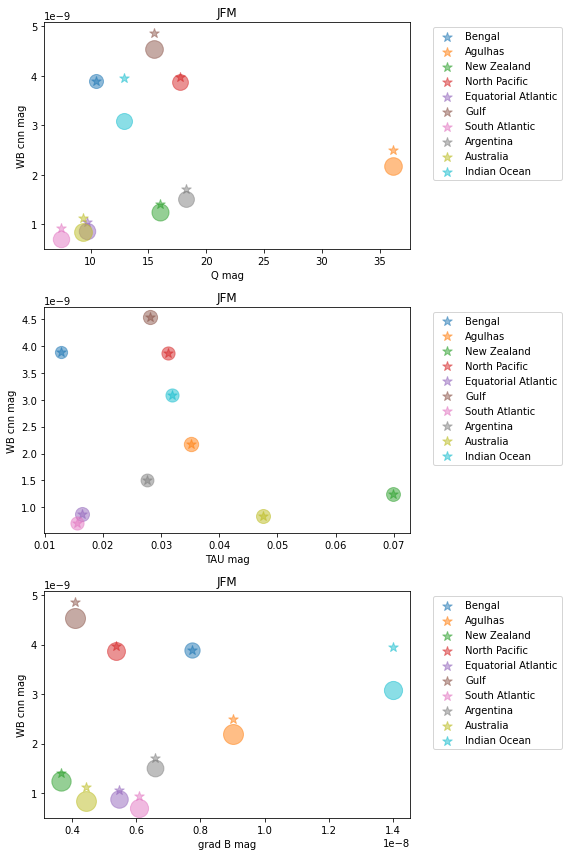

In [39]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(8,12))
fig.set_tight_layout(True)

ax = plt.subplot(3,1,1)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(Q_loc_mean_JFM[i_loc],WB_cnn_loc_mean_JFM[i_loc],color=c_loc,s=100+3*jacobian_loc[i_loc,0],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(Q_loc_mean_JFM[i_loc], WB_sg_loc_mean_JFM[i_loc],color=c_loc,s=100,marker='*',alpha=0.5)
    plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
plt.ylabel('WB cnn mag')
plt.xlabel('Q mag')
plt.title('JFM')
    
ax = plt.subplot(3,1,2)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(TAU_loc_mean_JFM[i_loc],WB_cnn_loc_mean_JFM[i_loc],color=c_loc,s=100+3*jacobian_loc[i_loc,1],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(TAU_loc_mean_JFM[i_loc],WB_cnn_loc_mean_JFM[i_loc],color=c_loc,s=100,marker='*',alpha=0.5)
    plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
plt.ylabel('WB cnn mag')
plt.xlabel('TAU mag')
plt.title('JFM')

ax = plt.subplot(3,1,3)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(grad_B_loc_mean_JFM[i_loc],WB_cnn_loc_mean_JFM[i_loc],color=c_loc,s=100+3*jacobian_loc[i_loc,2],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(grad_B_loc_mean_JFM[i_loc],WB_sg_loc_mean_JFM[i_loc],color=c_loc,s=100,marker='*',alpha=0.5)
    plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
plt.ylabel('WB cnn mag')
plt.xlabel('grad B mag')
plt.title('JFM')

plt.savefig('./figures/cnn_7l_k5_surface_inputs_magnitude_Jacobian_JFM')


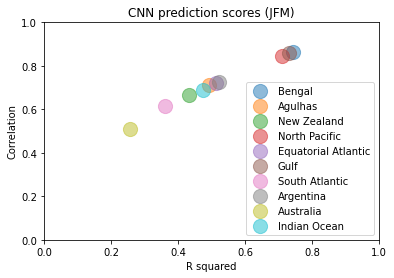

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(6,4))

from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(r2score_loc_JFM[i_loc],corr_loc_JFM[i_loc],color=c_loc,s=200,alpha=0.5)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.legend(label_list)
plt.xlabel('R squared')
plt.ylabel('Correlation')
plt.title('CNN prediction scores (JFM)')
plt.savefig('./figures/cnn_7l_k5_surface_inputs_R2_corr_scores_JFM')

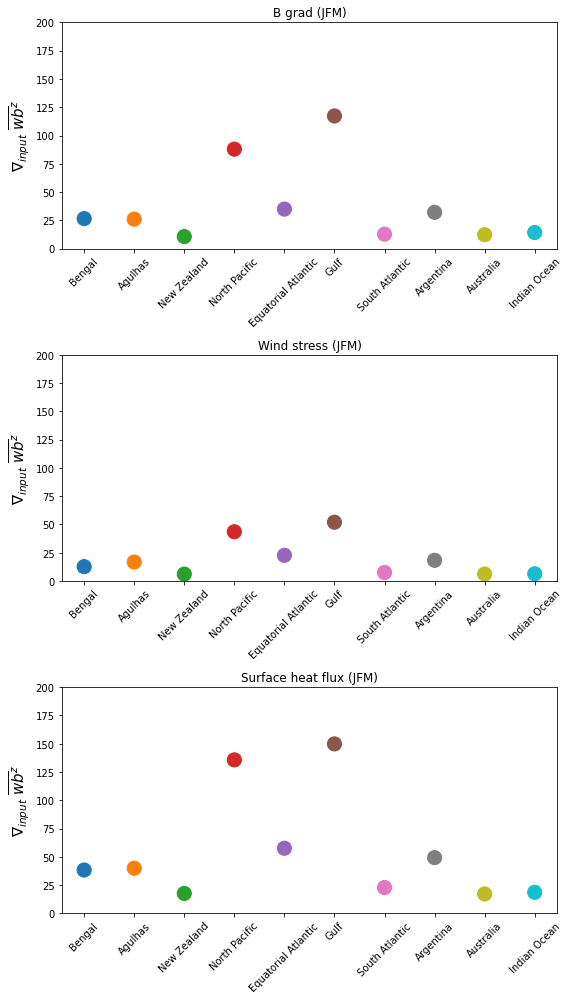

In [41]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(8,14))
fig.set_tight_layout(True)

ax = plt.subplot(3,1,1)
plt.scatter(np.arange(10),jacobian_loc_JFM[:,0],c=range(10),s=200,cmap='tab10')
my_xticks = label_list
plt.xticks(np.arange(10), my_xticks,rotation = 45);
plt.title('B grad (JFM)')
plt.ylim([0,200])
plt.ylabel(r'$\nabla_{input}\ \overline{wb}^z}$',fontsize=15)

ax = plt.subplot(3,1,2)
plt.scatter(np.arange(10),jacobian_loc_JFM[:,1],c=range(10),s=200,cmap='tab10')
my_xticks = label_list
plt.xticks(np.arange(10), my_xticks,rotation = 45);
plt.title('Wind stress (JFM)')
plt.ylim([0,200])
plt.ylabel(r'$\nabla_{input}\ \overline{wb}^z}$',fontsize=15)

ax = plt.subplot(3,1,3)
plt.scatter(np.arange(10),jacobian_loc_JFM[:,2],c=range(10),s=200,cmap='tab10')
my_xticks = label_list
plt.xticks(np.arange(10), my_xticks,rotation = 45);
plt.title('Surface heat flux (JFM)',fontsize=12)
plt.ylabel(r'$\nabla_{input}\ \overline{wb}^z}$',fontsize=15)
plt.ylim([0,200])
plt.savefig('./figures/cnn_7l_k5_surface_inputs_Jacobian_JFM')

## positive fluxes

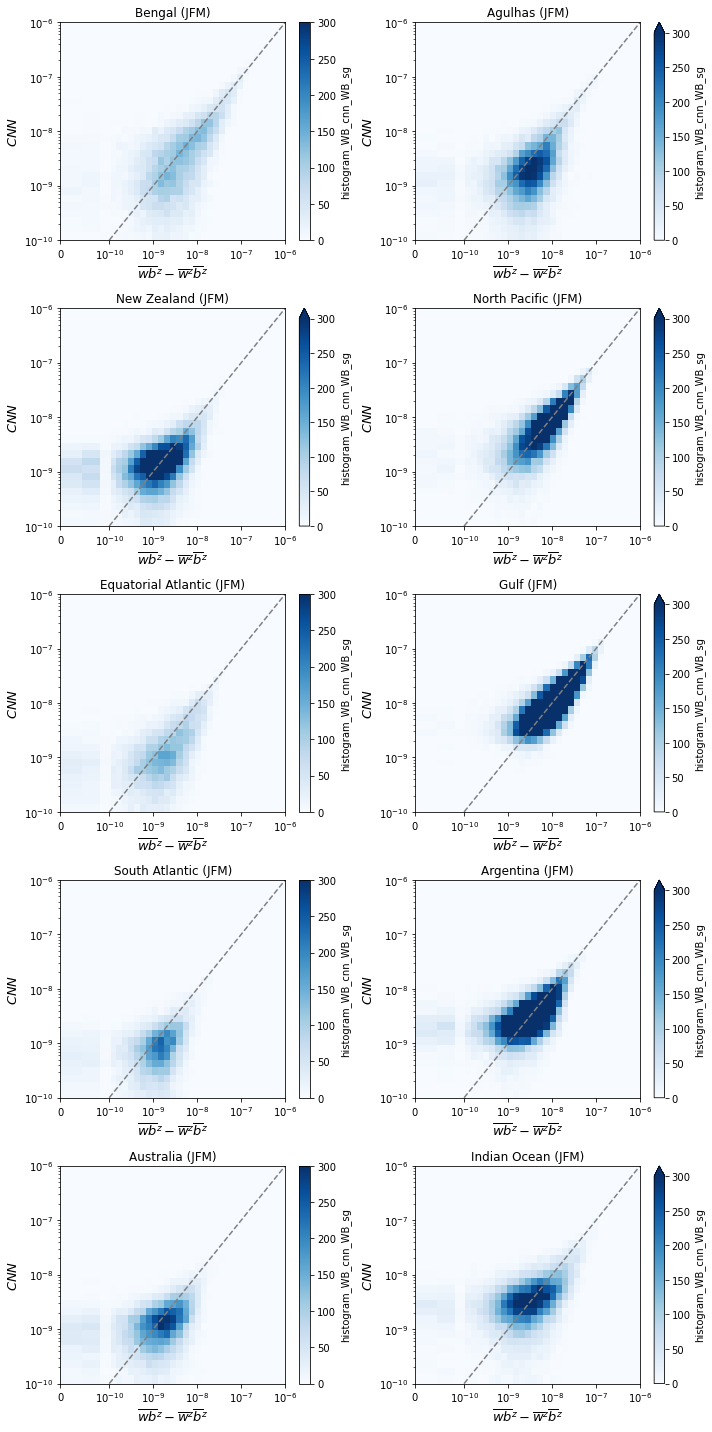

In [42]:
import matplotlib as mpl
from xhistogram.xarray import histogram as xhist

fig, axes = plt.subplots(nrows=5, ncols=2,figsize=(10,20))
fig.set_tight_layout(True)

i_plot=0

for i_loc in range(10):
    
    WB_cnn  = xr.DataArray(WB_cnn_loc_flat[i_loc,:])
    WB_cnn.name = 'WB_cnn'
    WB_sg  = xr.DataArray(WB_sg_loc_flat[i_loc,:])
    WB_sg.name = 'WB_sg'

    xhist_CNN = xhist(WB_cnn, 
      WB_sg,
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),
                                            np.logspace(-10,-6,30)))))
           ]
     ).compute()
    
    ax = plt.subplot(5,2,i_loc+1)
    xhist_CNN.plot(vmax=300, cmap='Blues')
    ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
    ax.set_xscale('symlog', linthresh=1e-10)
    ax.set_yscale('log')
    ax.set_ylim([1e-10,1e-6])
    ax.set_xlim([0,1e-6])
    ax.set_xlabel(r"$\overline{wb}^z-\overline{w}^z\overline{b}^z$", fontsize=13)
    ax.set_ylabel(r"$CNN$", 
                  fontsize=13)
    plt.title(label_list[i_loc]+' (JFM)')


plt.savefig('./figures/cnn_7l_k5_surface_inputs_all_positive_fluxes_seasonality_JFM')

## negative fluxes

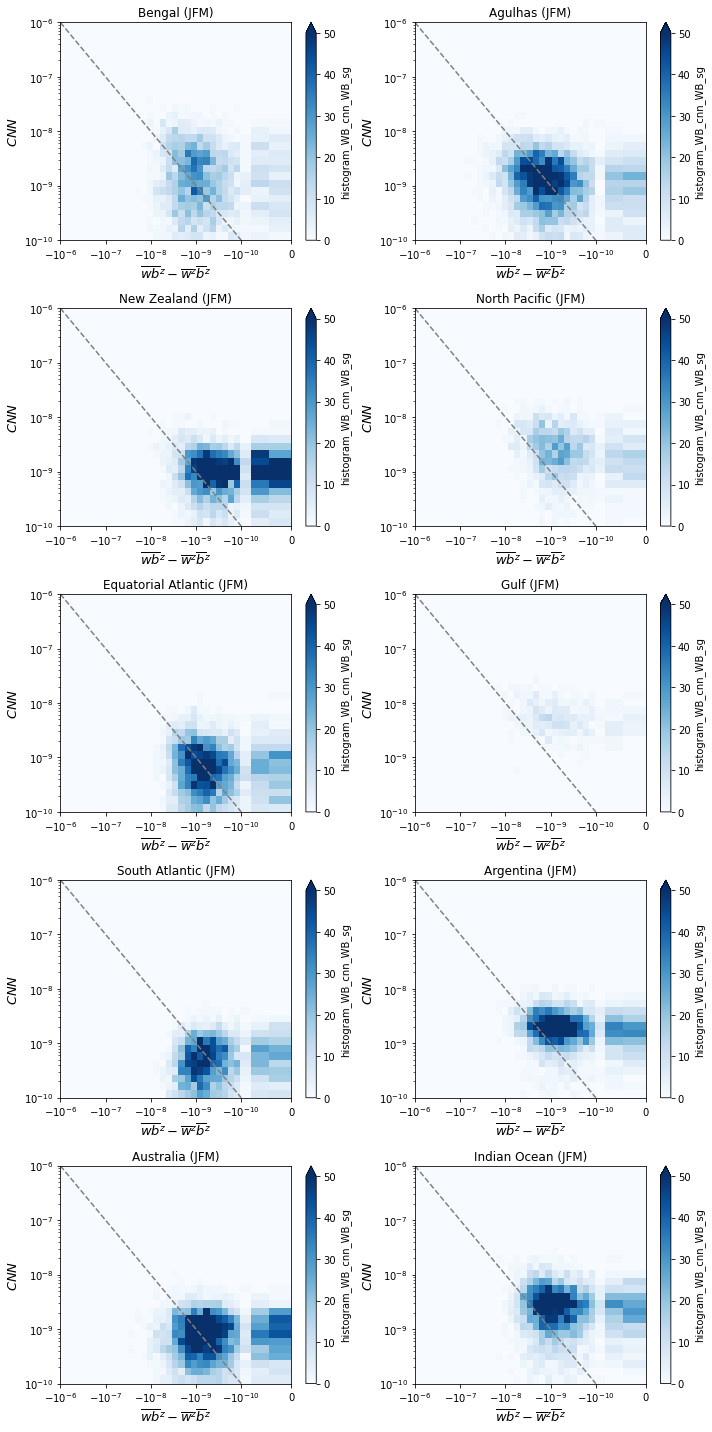

In [43]:
import matplotlib as mpl
from xhistogram.xarray import histogram as xhist

fig, axes = plt.subplots(nrows=5, ncols=2,figsize=(10,20))
fig.set_tight_layout(True)

i_plot=0

for i_loc in range(10):
    
    WB_cnn  = xr.DataArray(WB_cnn_loc_flat[i_loc,:])
    WB_cnn.name = 'WB_cnn'
    WB_sg  = xr.DataArray(WB_sg_loc_flat[i_loc,:])
    WB_sg.name = 'WB_sg'

    xhist_CNN = xhist(WB_cnn, 
      WB_sg,
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),
                                            np.logspace(-10,-6,30)))))
           ]
     ).compute()
    ax = plt.subplot(5,2,i_loc+1)
    xhist_CNN.plot(vmax=50, cmap='Blues')
    ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
    ax.set_xscale('symlog', linthresh=1e-10)
    ax.set_yscale('log')
    ax.set_ylim([1e-10,1e-6])
    ax.set_xlim([-1e-6,0])
    ax.set_xlabel(r"$\overline{wb}^z-\overline{w}^z\overline{b}^z$", fontsize=13)
    ax.set_ylabel(r"$CNN$", 
                  fontsize=13)
    plt.title(label_list[i_loc]+' (JFM)')


plt.savefig('./figures/cnn_7l_k5_surface_inputs_all_negative_fluxes_seasonality_JFM')

# Seasonality - JAS


In [44]:
# build test loader for JFM and JAS
b_x_JAS, b_y_JAS, prediction_JAS = plot_model_direct(cnn_submeso, criterion, loader_test_JAS,len(torch_dataset_test_JAS))

Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.40867813238059375


In [45]:
jacobian_JAS = Jacobian_norm(b_x,prediction)

Text(0, 0.5, '$\\nabla_{input}\\ \\overline{wb}^z}$')

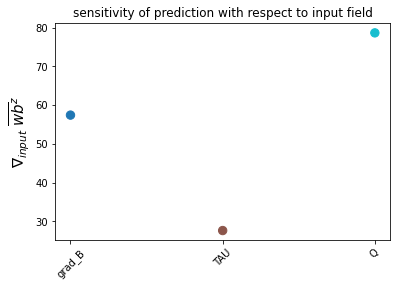

In [46]:
plt.scatter(np.arange(3),jacobian_JAS.detach(),c=range(3),s=70,cmap='tab10')
my_xticks = ['grad_B','TAU', 'Q']
plt.xticks(np.arange(3), my_xticks,rotation = 45);
plt.title('sensitivity of prediction with respect to input field')
plt.ylabel(r'$\nabla_{input}\ \overline{wb}^z}$',fontsize=15)

In [78]:
# renormalize using mean and std 
WB_sg_mean_test = WB_sg_mean[JAS_test_ind]
WB_sg_std_test = WB_sg_std[JAS_test_ind] 

mean_tile = np.transpose(np.tile(WB_sg_mean_test,(40,40,1,1)))
std_tile = np.transpose(np.tile(WB_sg_std_test,(40,40,1,1)))

WB_cnn_JAS = np.squeeze((cnn_submeso(b_x_JAS.to(device)).detach().cpu().numpy()*std_tile + mean_tile))

WB_sg_JAS = np.squeeze(xr.DataArray((b_y_JAS.detach().cpu().numpy()*std_tile + mean_tile)))

WB_cnn_loc = np.empty((10,len(JAS_test_ind),40,40))
WB_cnn_loc[:] = np.nan
WB_cnn_loc_flat = np.empty((10,len(JAS_test_ind)*40*40))

WB_sg_loc = np.empty((10,len(JAS_test_ind),40,40))
WB_sg_loc[:] = np.nan
WB_sg_loc_flat = np.empty((10,len(JAS_test_ind)*40*40))

# renormalize to physical space

Q_mean_test_tile = np.transpose(np.tile(Q_mean[JAS_test_ind],(40,40,1)))
Q_std_test_tile = np.transpose(np.tile(Q_std[JAS_test_ind],(40,40,1)))
Q_phys = Q[JAS_test_ind]*Q_std_test_tile + Q_mean_test_tile

TAU_mean_test_tile = np.transpose(np.tile(TAU_mean[JAS_test_ind],(40,40,1)))
TAU_std_test_tile = np.transpose(np.tile(TAU_std[JAS_test_ind],(40,40,1)))
TAU_phys = TAU[JAS_test_ind]*TAU_std_test_tile + TAU_mean_test_tile

grad_B_mean_test_tile = np.transpose(np.tile(grad_B_mean[JAS_test_ind],(40,40,1)))
grad_B_std_test_tile = np.transpose(np.tile(grad_B_std[JAS_test_ind],(40,40,1)))
grad_B_phys = grad_B[JAS_test_ind]*grad_B_std_test_tile + grad_B_mean_test_tile

Q_loc = np.empty((10,len(JAS_test_ind),40,40))
TAU_loc = np.empty((10,len(JAS_test_ind),40,40))
grad_B_loc = np.empty((10,len(JAS_test_ind),40,40))

WB_sg_loc_mean_JAS = np.empty((10,1))
WB_cnn_loc_mean_JAS = np.empty((10,1))
Q_loc_mean_JAS = np.empty((10,1))
TAU_loc_mean_JAS = np.empty((10,1))
grad_B_loc_mean_JAS = np.empty((10,1))
i_max_loc = np.empty((10,1))


# cell size 
drF_test_JAS = drF[JAS_test_ind] 
drF_test_loc = np.empty((10,len(JAS_test_ind),40,40))
drF_test_loc[:] = np.nan


for i_loc in range(10):
    drF_test_loc[i_loc,location_index[JAS_test_ind]==i_loc,:,:] = drF_test_JAS[location_index[JAS_test_ind]==i_loc]

    WB_cnn_loc[i_loc,location_index[JAS_test_ind]==i_loc,:,:] = WB_cnn_JAS[location_index[JAS_test_ind]==i_loc]
    WB_cnn_loc_flat[i_loc,:]  = WB_cnn_loc[i_loc].flatten()
    WB_cnn_loc_mean_JAS[i_loc] = np.nanmax((np.squeeze(np.apply_over_axes(np.nansum, WB_cnn_loc[i_loc]*WB_cnn_loc[i_loc]*drF_test_loc[i_loc], [0,1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)
    i_max_loc[i_loc] = np.argmax((np.squeeze(np.apply_over_axes(np.nansum, WB_cnn_loc[i_loc]*WB_cnn_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)

    
    WB_sg_loc[i_loc,location_index[JAS_test_ind]==i_loc,:,:] = WB_sg_JAS[location_index[JAS_test_ind]==i_loc]
    WB_sg_loc_flat[i_loc,:]  = WB_sg_loc[i_loc].flatten()
    WB_sg_loc_mean_JAS[i_loc] = ((np.squeeze(np.apply_over_axes(np.nansum, WB_sg_loc[i_loc]*WB_sg_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)[int(i_max_loc[i_loc])]
    
    Q_loc[i_loc,location_index[JAS_test_ind]==i_loc,:,:] = Q_phys[location_index[JAS_test_ind]==i_loc]
    Q_loc_mean_JAS[i_loc] = ((np.squeeze(np.apply_over_axes(np.nansum, Q_loc[i_loc]*Q_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)[int(i_max_loc[i_loc])]
    
    TAU_loc[i_loc,location_index[JAS_test_ind]==i_loc,:,:] = TAU_phys[location_index[JAS_test_ind]==i_loc]
    TAU_loc_mean_JAS[i_loc] = ((np.squeeze(np.apply_over_axes(np.nansum, TAU_loc[i_loc]*TAU_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)[int(i_max_loc[i_loc])]
    
    grad_B_loc[i_loc,location_index[JAS_test_ind]==i_loc,:,:] = grad_B_phys[location_index[JAS_test_ind]==i_loc]
    grad_B_loc_mean_JAS[i_loc] = ((np.squeeze(np.apply_over_axes(np.nansum, grad_B_loc[i_loc]*grad_B_loc[i_loc]*drF_test_loc[i_loc], [1,2])) / np.nansum(drF_test_loc[i_loc]))**0.5)[int(i_max_loc[i_loc])]
    


In [53]:
# Jacobian per location JAS

jacobian_loc_JAS = np.empty((10,3))
r2score_loc_JAS = np.empty((10,1))
corr_loc_JAS = np.empty((10,1))

for i_loc in range(10):
    torch_dataset_test_loc = Data.TensorDataset(
        torch.from_numpy(X_input[JAS_test_ind[location_index[JAS_test_ind]==i_loc]]).double(),
        torch.from_numpy(Y_output[JAS_test_ind[location_index[JAS_test_ind]==i_loc]]).double(),    
    )

    BATCH_SIZE_TEST = len(torch_dataset_test_loc)

    loader_test_loc = Data.DataLoader(
        dataset=torch_dataset_test_loc, batch_size=BATCH_SIZE_TEST, shuffle=False
    )


    loader_test_loc
    b_x_loc, b_y_loc, prediction_loc = plot_model_direct(cnn_submeso, criterion, loader_test_loc,len(torch_dataset_test_loc))

    jacobian_loc_JAS[i_loc,:] = Jacobian_norm(b_x_loc,prediction_loc).detach().cpu().numpy()
        
    r2score_loc_JAS[i_loc] = r2_score(b_y_loc.detach().cpu().numpy().flatten(), prediction_loc.detach().cpu().numpy().flatten())
    
    corr_loc_JAS[i_loc] = stats.pearsonr(b_y_loc.detach().cpu().numpy().flatten(), prediction_loc.detach().cpu().numpy().flatten())[0]

Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.5130914099464237
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.6966060818472153
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.4596780331239101
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.16561857770016553
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.36103674369391225
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.09837967258917173
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.36800532209362896
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.3343632783446134
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.4712882377046545
Training starts on device Quadro RTX 8000, number of samples 1
test loss: 0.573266418716022


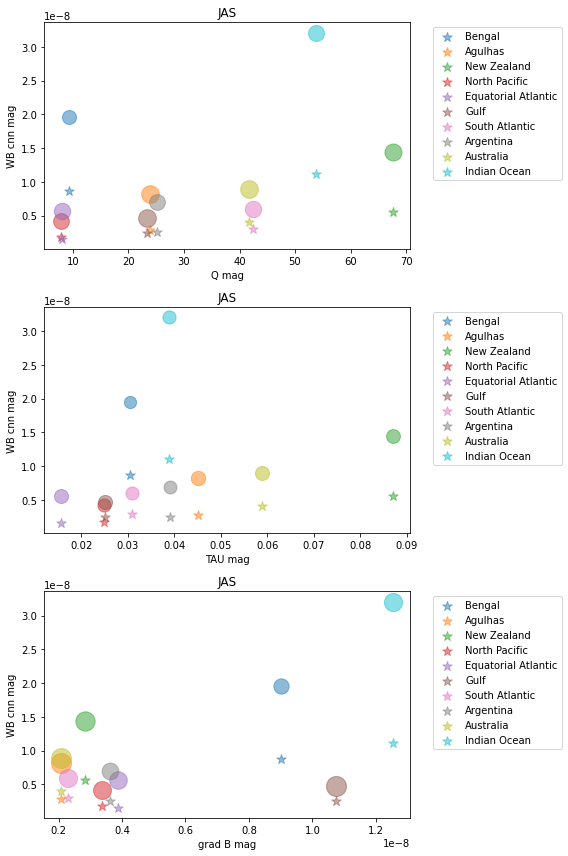

In [54]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(8,12))
fig.set_tight_layout(True)

ax = plt.subplot(3,1,1)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(Q_loc_mean_JAS[i_loc],WB_cnn_loc_mean_JAS[i_loc],color=c_loc,s=100+3*jacobian_loc[i_loc,0],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(Q_loc_mean_JAS[i_loc], WB_sg_loc_mean_JAS[i_loc],color=c_loc,s=100,marker='*',alpha=0.5)
    plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
plt.ylabel('WB cnn mag')
plt.xlabel('Q mag')
plt.title('JAS')
    
ax = plt.subplot(3,1,2)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(TAU_loc_mean_JAS[i_loc],WB_cnn_loc_mean_JAS[i_loc],color=c_loc,s=100+3*jacobian_loc[i_loc,1],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(TAU_loc_mean_JAS[i_loc],WB_sg_loc_mean_JAS[i_loc],color=c_loc,s=100,marker='*',alpha=0.5)
    plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
plt.ylabel('WB cnn mag')
plt.xlabel('TAU mag')
plt.title('JAS')

ax = plt.subplot(3,1,3)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(grad_B_loc_mean_JAS[i_loc],WB_cnn_loc_mean_JAS[i_loc],color=c_loc,s=100+3*jacobian_loc[i_loc,2],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(grad_B_loc_mean_JAS[i_loc],WB_sg_loc_mean_JAS[i_loc],color=c_loc,s=100,marker='*',alpha=0.5)
    plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
plt.ylabel('WB cnn mag')
plt.xlabel('grad B mag')
plt.title('JAS')

plt.savefig('./figures/cnn_7l_k5_surface_inputs_magnitude_Jacobian_JAS')


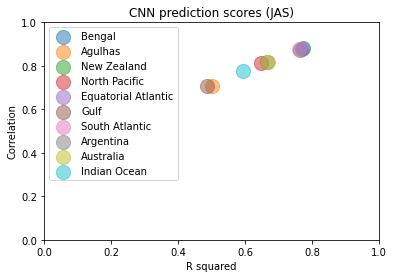

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(6,4))

from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(r2score_loc_JAS[i_loc],corr_loc_JAS[i_loc],color=c_loc,s=200,alpha=0.5)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.legend(label_list)
plt.xlabel('R squared')
plt.ylabel('Correlation')
plt.title('CNN prediction scores (JAS)')
plt.savefig('./figures/cnn_7l_k5_surface_inputs_R2_corr_scores_JAS')

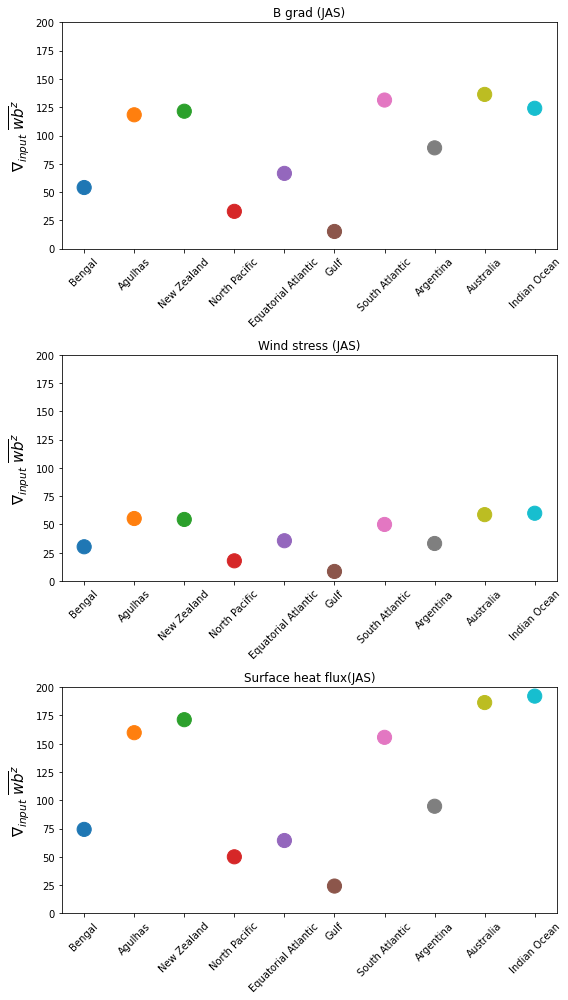

In [56]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(8,14))
fig.set_tight_layout(True)

ax = plt.subplot(3,1,1)
plt.scatter(np.arange(10),jacobian_loc_JAS[:,0],c=range(10),s=200,cmap='tab10')
my_xticks = label_list
plt.xticks(np.arange(10), my_xticks,rotation = 45);
plt.title('B grad (JAS)')
plt.ylim([0,200])
plt.ylabel(r'$\nabla_{input}\ \overline{wb}^z}$',fontsize=15)

ax = plt.subplot(3,1,2)
plt.scatter(np.arange(10),jacobian_loc_JAS[:,1],c=range(10),s=200,cmap='tab10')
my_xticks = label_list
plt.xticks(np.arange(10), my_xticks,rotation = 45);
plt.title('Wind stress (JAS)')
plt.ylim([0,200])
plt.ylabel(r'$\nabla_{input}\ \overline{wb}^z}$',fontsize=15)

ax = plt.subplot(3,1,3)
plt.scatter(np.arange(10),jacobian_loc_JAS[:,2],c=range(10),s=200,cmap='tab10')
my_xticks = label_list
plt.xticks(np.arange(10), my_xticks,rotation = 45);
plt.title('Surface heat flux(JAS)')
plt.ylabel(r'$\nabla_{input}\ \overline{wb}^z}$',fontsize=15)
plt.ylim([0,200])
plt.savefig('./figures/cnn_7l_k5_surface_inputs_Jacobian_JAS')

## positive fluxes

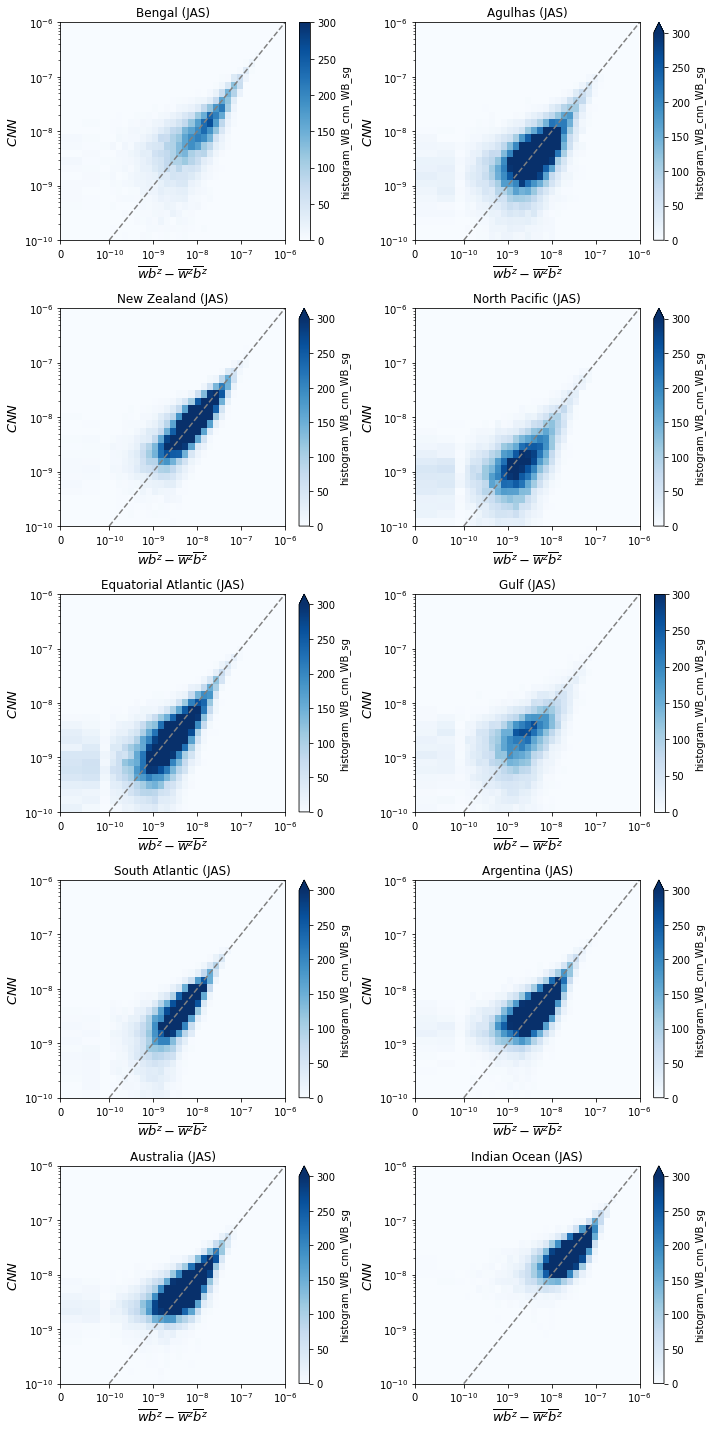

In [57]:
import matplotlib as mpl
from xhistogram.xarray import histogram as xhist

fig, axes = plt.subplots(nrows=5, ncols=2,figsize=(10,20))
fig.set_tight_layout(True)

i_plot=0

for i_loc in range(10):
    
    WB_cnn  = xr.DataArray(WB_cnn_loc_flat[i_loc,:])
    WB_cnn.name = 'WB_cnn'
    WB_sg  = xr.DataArray(WB_sg_loc_flat[i_loc,:])
    WB_sg.name = 'WB_sg'

    xhist_CNN = xhist(WB_cnn, 
      WB_sg,
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),
                                            np.logspace(-10,-6,30)))))
           ]
     ).compute()
    
    
    ax = plt.subplot(5,2,i_loc+1)
    xhist_CNN.plot(vmax=300, cmap='Blues')
    ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
    ax.set_xscale('symlog', linthresh=1e-10)
    ax.set_yscale('log')
    ax.set_ylim([1e-10,1e-6])
    ax.set_xlim([0,1e-6])
    ax.set_xlabel(r"$\overline{wb}^z-\overline{w}^z\overline{b}^z$", fontsize=13)
    ax.set_ylabel(r"$CNN$", 
                  fontsize=13)
    plt.title(label_list[i_loc]+' (JAS)')


plt.savefig('./figures/cnn_7l_k5_surface_inputs_all_positive_fluxes_seasonality_JAS')

## negative fluxes

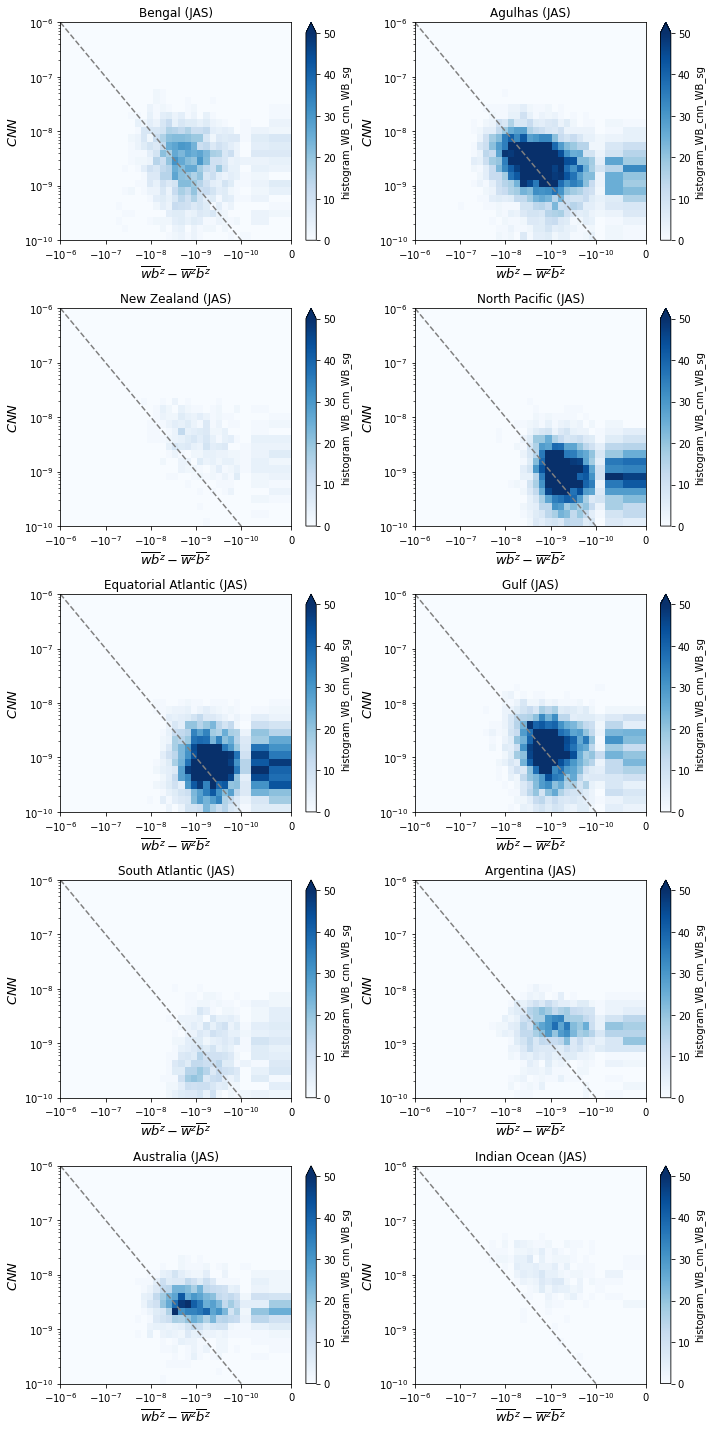

In [58]:
import matplotlib as mpl
from xhistogram.xarray import histogram as xhist

fig, axes = plt.subplots(nrows=5, ncols=2,figsize=(10,20))
fig.set_tight_layout(True)

i_plot=0

for i_loc in range(10):
    
    WB_cnn  = xr.DataArray(WB_cnn_loc_flat[i_loc,:])
    WB_cnn.name = 'WB_cnn'
    WB_sg  = xr.DataArray(WB_sg_loc_flat[i_loc,:])
    WB_sg.name = 'WB_sg'

    xhist_CNN = xhist(WB_cnn, 
      WB_sg,
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),
                                            np.logspace(-10,-6,30)))))
           ]
     ).compute()
    ax = plt.subplot(5,2,i_loc+1)
    xhist_CNN.plot(vmax=50, cmap='Blues')
    ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
    ax.set_xscale('symlog', linthresh=1e-10)
    ax.set_yscale('log')
    ax.set_ylim([1e-10,1e-6])
    ax.set_xlim([-1e-6,0])
    ax.set_xlabel(r"$\overline{wb}^z-\overline{w}^z\overline{b}^z$", fontsize=13)
    ax.set_ylabel(r"$CNN$", 
                  fontsize=13)
    plt.title(label_list[i_loc]+' (JAS)')


plt.savefig('./figures/cnn_7l_k5_surface_inputs_all_negative_fluxes_seasonality_JAS')

# input magnitude and sensitivity

In [59]:
# split into global winter and summer

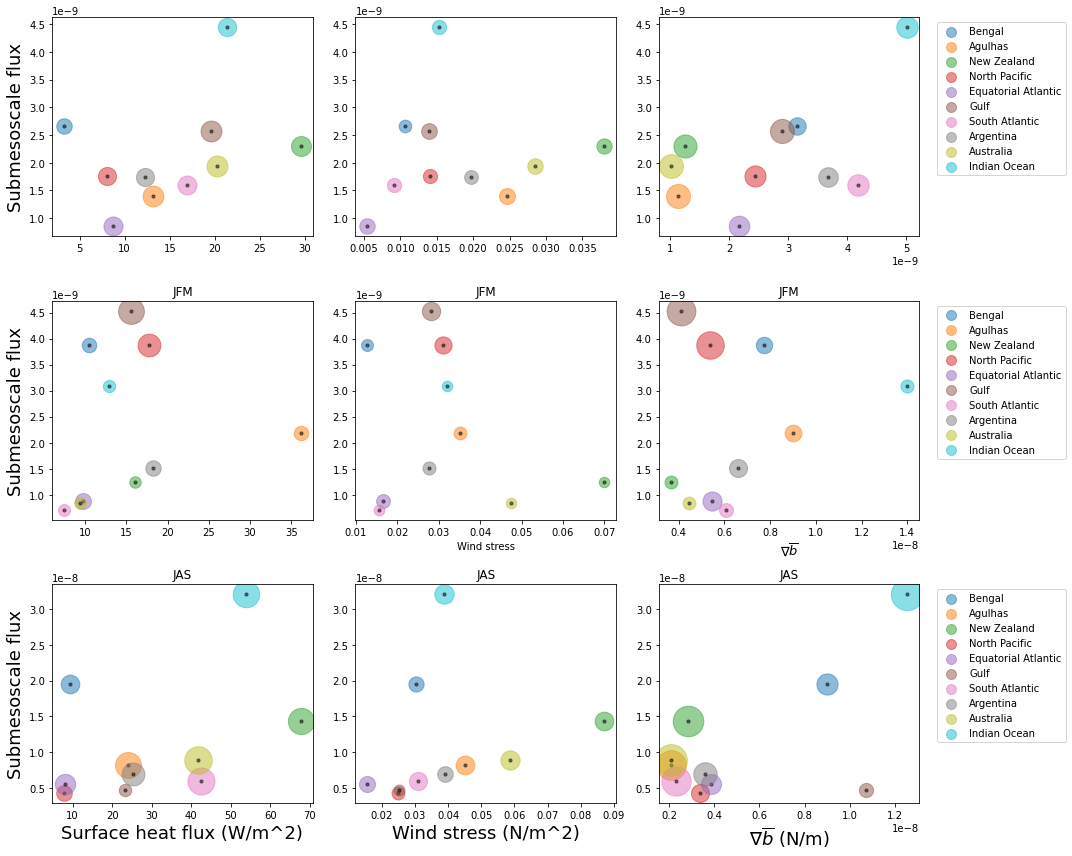

In [79]:
fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(15,12))
fig.set_tight_layout(True)

ax = plt.subplot(3,3,1)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(Q_loc_mean[i_loc],WB_cnn_loc_mean[i_loc],color=c_loc,s=80+5*jacobian_loc[i_loc,0],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(Q_loc_mean[i_loc],WB_cnn_loc_mean[i_loc],color='k',s=10,marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(Q_loc_mean[i_loc]*np.nan, WB_sg_loc_mean[i_loc],color=c_loc,s=100,marker='o',alpha=0.5)
    #plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    #plt.xlim([0,150])
    #plt.ylim([0,4e-8])
plt.ylabel('Submesoscale flux', fontsize=18)
#plt.xlabel('Surface heat flux')

    
ax = plt.subplot(3,3,2)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(TAU_loc_mean[i_loc],WB_cnn_loc_mean[i_loc],color=c_loc,s=80+5*jacobian_loc[i_loc,1],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(TAU_loc_mean[i_loc],WB_cnn_loc_mean[i_loc],color='k',s=10,marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(TAU_loc_mean[i_loc]*np.nan,WB_sg_loc_mean[i_loc],color=c_loc,s=100,marker='o',alpha=0.5)
    #plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    #plt.xlim([0,3e-1])
    #plt.ylim([0,4e-8])
#plt.ylabel('WB cnn mag')
#plt.xlabel('Wind stress')


ax = plt.subplot(3,3,3)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(grad_B_loc_mean[i_loc],WB_cnn_loc_mean[i_loc],color=c_loc,s=80+5*jacobian_loc[i_loc,2],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(grad_B_loc_mean[i_loc],WB_cnn_loc_mean[i_loc],color='k',s=10,marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(grad_B_loc_mean[i_loc]*np.nan,WB_sg_loc_mean[i_loc],color=c_loc,s=100,marker='o',alpha=0.5)
    plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    #plt.xlim([0,6e-8])
    #plt.ylim([0,4e-8])
#plt.ylabel('WB cnn mag')
#plt.xlabel(r"$\nabla\overline{b}$", fontsize=13)



ax = plt.subplot(3,3,4)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(Q_loc_mean_JFM[i_loc],WB_cnn_loc_mean_JFM[i_loc],color=c_loc,s=80+5*jacobian_loc_JFM[i_loc,0],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(Q_loc_mean_JFM[i_loc],WB_cnn_loc_mean_JFM[i_loc],color='k',s=10,marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(Q_loc_mean_JFM[i_loc]*np.nan, WB_cnn_loc_mean_JFM[i_loc],color=c_loc,s=100,marker='o',alpha=0.5)
    #plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    #plt.xlim([0,150])
    #plt.ylim([0,4e-8])
plt.ylabel('Submesoscale flux', fontsize=18)
#plt.xlabel('Surface heat flux')
plt.title('JFM')
    
ax = plt.subplot(3,3,5)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(TAU_loc_mean_JFM[i_loc],WB_cnn_loc_mean_JFM[i_loc],color=c_loc,s=80+5*jacobian_loc_JFM[i_loc,1],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(TAU_loc_mean_JFM[i_loc],WB_cnn_loc_mean_JFM[i_loc],color='k',s=10,marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(TAU_loc_mean[i_loc]*np.nan,WB_sg_loc_mean[i_loc],color=c_loc,s=100,marker='o',alpha=0.5)
    #plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    #plt.xlim([0,3e-1])
    #plt.ylim([0,4e-8])
#plt.ylabel('WB cnn mag')
plt.xlabel('Wind stress')
plt.title('JFM')

ax = plt.subplot(3,3,6)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(grad_B_loc_mean_JFM[i_loc],WB_cnn_loc_mean_JFM[i_loc],color=c_loc,s=80+5*jacobian_loc_JFM[i_loc,2],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(grad_B_loc_mean_JFM[i_loc],WB_cnn_loc_mean_JFM[i_loc],color='k',s=10,marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(grad_B_loc_mean[i_loc]*np.nan,WB_sg_loc_mean[i_loc],color=c_loc,s=100,marker='o',alpha=0.5)
    plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    #plt.xlim([0,6e-8])
    #plt.ylim([0,4e-8])
#plt.ylabel('WB cnn mag')
plt.xlabel(r"$\nabla\overline{b}$", fontsize=13)
plt.title('JFM')



ax = plt.subplot(3,3,7)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(Q_loc_mean_JAS[i_loc],WB_cnn_loc_mean_JAS[i_loc],color=c_loc,s=80+5*jacobian_loc_JAS[i_loc,0],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(Q_loc_mean_JAS[i_loc],WB_cnn_loc_mean_JAS[i_loc],color='k',s=10,marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(Q_loc_mean[i_loc]*np.nan, WB_sg_loc_mean[i_loc],color=c_loc,s=100,marker='o',alpha=0.5)
    #plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    #plt.xlim([0,150])
    #plt.ylim([0,4e-8])
plt.ylabel('Submesoscale flux', fontsize=18)
plt.xlabel('Surface heat flux (W/m^2)', fontsize=18)
plt.title('JAS')
    
ax = plt.subplot(3,3,8)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(TAU_loc_mean_JAS[i_loc],WB_cnn_loc_mean_JAS[i_loc],color=c_loc,s=80+5*jacobian_loc_JAS[i_loc,1],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(TAU_loc_mean_JAS[i_loc],WB_cnn_loc_mean_JAS[i_loc],color='k',s=10,marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(TAU_loc_mean[i_loc]*np.nan,WB_sg_loc_mean[i_loc],color=c_loc,s=100,marker='o',alpha=0.5)
    #plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    #plt.xlim([0,3e-1])
    #plt.ylim([0,4e-8])
#plt.ylabel('WB cnn mag')
plt.xlabel('Wind stress (N/m^2)', fontsize=18)
plt.title('JAS')

ax = plt.subplot(3,3,9)
from matplotlib.pyplot import cm
cmap='tab10'
color = cm.tab10(np.linspace(0, 1, 10))
for i_loc, c_loc in zip(range(10),color):
    plt.scatter(grad_B_loc_mean_JAS[i_loc],WB_cnn_loc_mean_JAS[i_loc],color=c_loc,s=80+5*jacobian_loc_JAS[i_loc,2],marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(grad_B_loc_mean_JAS[i_loc],WB_cnn_loc_mean_JAS[i_loc],color='k',s=10,marker='o',alpha=0.5,label='_nolegend_')
    plt.scatter(grad_B_loc_mean[i_loc]*np.nan,WB_sg_loc_mean[i_loc],color=c_loc,s=100,marker='o',alpha=0.5)
    plt.legend(label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    #plt.xlim([0,6e-8])
    #plt.ylim([0,4e-8])
#plt.ylabel('CNN prediction', fontsize=13)
plt.xlabel(r"$\nabla\overline{b}$ (N/m)", fontsize=18)
plt.title('JAS')

plt.savefig('./figures/cnn_7l_k5_surface_inputs_mean_Jacobian')
